In [1266]:
## BUSINESS USE CASE -- PLANE CRASHES HAPPEN!! HERE'S HOW YOU CAN AVOID DYING!!

In [1267]:
import csv
import pickle
import pandas as pd
import numpy as np
import patsy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import learning_curve, KFold, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from collections import Counter
import matplotlib.style as style
style.use('fivethirtyeight')
%matplotlib inline

from __future__ import print_function, division

# Get pandas and postgres to work together
import psycopg2 as pg
import pandas.io.sql as pd_sql
plt.rc('font', size=18) 

In [1268]:
with open('airline_crash.pkl', 'rb') as picklefile:
    df = pickle.load(picklefile)

In [1269]:
state_df = pd.concat([df['Event_Id'], df['Location'].str.split(', ', expand=True)], axis=1)

In [1270]:
state_df['City'] = state_df[0]
state_df['State'] = state_df[1]

state_df = state_df.drop([0,1,2,3,4],1)

In [1271]:
df.reset_index(inplace=True)
state_df.reset_index(inplace=True)

In [1272]:
df = pd.merge(df, state_df, on='index')

df = df.drop(['Location'],1)

In [1273]:
df.Latitude = df.Latitude.astype('float')
df.Longitude = df.Longitude.astype('float')
df.Total_Fatal_Injuries = df.Total_Fatal_Injuries.astype('float')
df.Total_Serious_Injuries = df.Total_Serious_Injuries.astype('float')
df.Total_Minor_Injuries = df.Total_Minor_Injuries.astype('float')
df.Total_Uninjured = df.Total_Uninjured.astype('float')
df.Number_Engines = df.Number_Engines.astype('float')

df['Event_Date'] = pd.to_datetime(df['Event_Date'])

In [1274]:
df.head()

,index,Event_Id_x,Investigation_Type,Accident_Number,Event_Date,Country,Latitude,Longitude,Airport_Code,Airport_Name,...,Total_Serious_Injuries,Total_Minor_Injuries,Total_Uninjured,Weather_Condition,Broad_Phase_of_Flight,Report_Status,Publication_Date,Event_Id_y,City,State
0,0,20180719X01751,Accident,CEN18LA281,2018-07-19,United States,32.540277,-93.745000,DTN,Shreveport Executive,...,NaN,NaN,1.0,VMC,MANEUVERING,Preliminary,07/23/2018,20180719X01751,Shreveport,LA
1,1,20180717X23051,Accident,GAA18CA428,2018-07-17,United States,36.124445,-86.678056,BNA,Nashville Intl,...,NaN,NaN,NaN,VMC,NaN,Preliminary,07/19/2018,20180717X23051,Nashville,TN
2,2,20180717X82154,Accident,CEN18LA276,2018-07-17,United States,29.868056,-95.795000,IWS,West Houston,...,NaN,NaN,1.0,VMC,NaN,Preliminary,07/19/2018,20180717X82154,Katy,TX
3,3,20180716X44947,Accident,GAA18CA427,2018-07-16,United States,26.002222,-80.240000,HWO,NORTH PERRY,...,NaN,1.0,NaN,VMC,NaN,Preliminary,07/23/2018,20180716X44947,Hollywood,FL
4,4,20180716X60511,Accident,GAA18CA424,2018-07-16,United States,39.564722,-85.235555,N/A,NaN,...,NaN,1.0,NaN,NaN,NaN,Preliminary,07/19/2018,20180716X60511,New Castle,IN


In [1275]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81899 entries, 0 to 81898
Data columns (total 34 columns):
index                     81899 non-null int64
Event_Id_x                81899 non-null object
Investigation_Type        81899 non-null object
Accident_Number           81899 non-null object
Event_Date                81899 non-null datetime64[ns]
Country                   81392 non-null object
Latitude                  28059 non-null float64
Longitude                 28050 non-null float64
Airport_Code              46449 non-null object
Airport_Name              51554 non-null object
Injury_Severity           81899 non-null object
Aircraft_Damage           79321 non-null object
Aircraft_Category         25157 non-null object
Registration_Number       78414 non-null object
Make                      81828 non-null object
Model                     81800 non-null object
Amateur_Built             81267 non-null object
Number_Engines            77419 non-null float64
Engine_Type      

In [1276]:
df.Broad_Phase_of_Flight.value_counts()

LANDING        19925
TAKEOFF        15767
CRUISE         10911
MANEUVERING    10115
APPROACH        7940
TAXI            2401
CLIMB           2333
DESCENT         2264
GO-AROUND       1667
STANDING        1262
UNKNOWN          738
OTHER            164
Name: Broad_Phase_of_Flight, dtype: int64

In [1277]:
df.Broad_Phase_of_Flight.replace('CRUISE', 'INFLIGHT', inplace=True)
df.Broad_Phase_of_Flight.replace('MANEUVERING', 'INFLIGHT', inplace=True)
df.Broad_Phase_of_Flight.replace('GO-AROUND', 'INFLIGHT', inplace=True)
df.Broad_Phase_of_Flight.replace('APPROACH', 'LANDING', inplace=True)
df.Broad_Phase_of_Flight.replace('DESCENT', 'INFLIGHT', inplace=True)
df.Broad_Phase_of_Flight.replace('CLIMB', 'INFLIGHT', inplace=True)
df.Broad_Phase_of_Flight.replace('STANDING', 'TAXI', inplace=True)

In [1278]:
df['Make'] = df['Make'].str.upper()

In [1279]:
df[df['Make'] == 'AIRBUS']

,index,Event_Id_x,Investigation_Type,Accident_Number,Event_Date,Country,Latitude,Longitude,Airport_Code,Airport_Name,...,Total_Serious_Injuries,Total_Minor_Injuries,Total_Uninjured,Weather_Condition,Broad_Phase_of_Flight,Report_Status,Publication_Date,Event_Id_y,City,State
426,426,20180419X80338,Accident,DCA18LA163,2018-04-18,United States,NaN,NaN,ATL,Hartsfield-Jackson,...,NaN,NaN,288.0,NaN,TAKEOFF,Preliminary,05/01/2018,20180419X80338,Atlanta,GA
447,447,20180508X94008,Incident,ENG18WA025,2018-04-14,Australia,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,TAKEOFF,Foreign,NaN,20180508X94008,Brisbane,QLD
725,725,20180205X20338,Incident,ENG18WA011,2018-01-18,Australia,-17.370000,123.660556,asp,Alice Springs,...,NaN,NaN,255.0,NaN,NaN,Foreign,NaN,20180205X20338,Alice Springs,Australia
846,846,20171220X52223,Accident,DCA18CA055,2017-12-06,United States,26.072500,-80.152778,NaN,N/A,...,1.0,1.0,100.0,IMC,INFLIGHT,Probable Cause,06/18/2018,20171220X52223,Fort Lauderdale,FL
862,862,20171212X50255,Accident,DCA18CA043A,2017-12-03,United States,NaN,NaN,MIA,Miami International,...,NaN,NaN,NaN,VMC,NaN,Preliminary,03/07/2018,20171212X50255,Miami,FL
885,885,20171128X93434,Accident,DCA18LA024B,2017-11-27,United States,NaN,NaN,JFK,John F Kennedy International,...,NaN,NaN,NaN,NaN,TAXI,Preliminary,03/09/2018,20171128X93434,Jamaica,NY
1084,1084,20170930X94216,Accident,ENG17RA039,2017-09-30,Canada,NaN,NaN,NaN,N/A,...,NaN,NaN,521.0,NaN,NaN,Foreign,NaN,20170930X94216,Goose Bay,Canada
1085,1085,20171002X95003,Accident,DCA17CA214B,2017-09-30,United States,NaN,NaN,DCA,Reagan National,...,NaN,NaN,NaN,VMC,NaN,Preliminary,03/07/2018,20171002X95003,Washington DC,DC
1387,1387,20170807X70934,Accident,ANC17CA041,2017-08-03,United States,64.467778,-144.915000,NaN,N/A,...,NaN,NaN,2.0,VMC,LANDING,Probable Cause,09/22/2017,20170807X70934,Delta Junction,AK
1580,1580,20170709X81141,Incident,DCA17IA148,2017-07-07,United States,37.615278,-122.358056,SFO,San Francisco International,...,NaN,NaN,NaN,NaN,INFLIGHT,Preliminary,07/24/2017,20170709X81141,San Francisco,CA


In [1280]:
df[df['Make'] == 'BOEING']

,index,Event_Id_x,Investigation_Type,Accident_Number,Event_Date,Country,Latitude,Longitude,Airport_Code,Airport_Name,...,Total_Serious_Injuries,Total_Minor_Injuries,Total_Uninjured,Weather_Condition,Broad_Phase_of_Flight,Report_Status,Publication_Date,Event_Id_y,City,State
127,127,20180615X62948,Accident,GAA18CA354,2018-06-15,United States,42.422223,-87.867778,UGN,WAUKEGAN NATIONAL,...,NaN,NaN,1.0,VMC,NaN,Preliminary,07/03/2018,20180615X62948,WAUKEGAN,IL
250,250,20180529X13624,Incident,ENG18RA029,2018-05-24,Japan,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,TAKEOFF,Foreign,NaN,20180529X13624,Kumamoto,Japan
285,285,20180518X90259,Accident,GAA18CA286,2018-05-16,United States,44.827223,-93.461111,FCM,FLYING CLOUD,...,NaN,NaN,2.0,NaN,NaN,Preliminary,05/21/2018,20180518X90259,Minneapolis,MN
331,331,20180507X00658,Accident,DCA18CA169,2018-05-07,United States,39.179167,-76.667223,KBWI,Baltimore/Thurgood Marshall In,...,NaN,NaN,179.0,VMC,NaN,Preliminary,06/22/2018,20180507X00658,Baltimore,MD
431,431,20180417X23642,Accident,DCA18MA142,2018-04-17,United States,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,INFLIGHT,Preliminary,05/03/2018,20180417X23642,Philadelphia,PA
495,495,20180403X83025,Incident,ENG18WA021,2018-03-29,Hong Kong,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,LANDING,Foreign,NaN,20180403X83025,Chek Lap Kok,Hong Kong
632,632,20180213X95634,Incident,DCA18IA092,2018-02-13,United States,NaN,NaN,NaN,NaN,...,NaN,NaN,378.0,NaN,INFLIGHT,Preliminary,03/05/2018,20180213X95634,Honolulu,HI
664,664,20180222X04028,Incident,ENG18RA015,2018-02-05,New Zealand,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,INFLIGHT,Foreign,NaN,20180222X04028,Auckland,New Zealand
677,677,20180206X80222,Incident,DCA18WA088,2018-01-30,Israel,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,LANDING,Foreign,NaN,20180206X80222,Tel Aviv,Israel
700,700,20180205X00724,Incident,ENG18WA010,2018-01-25,Peru,-12.736944,-75.958056,NaN,NaN,...,NaN,NaN,99.0,NaN,NaN,Foreign,NaN,20180205X00724,Lima,Peru


In [1281]:
df[df['Make'] == 'BOMBARDIER']

,index,Event_Id_x,Investigation_Type,Accident_Number,Event_Date,Country,Latitude,Longitude,Airport_Code,Airport_Name,...,Total_Serious_Injuries,Total_Minor_Injuries,Total_Uninjured,Weather_Condition,Broad_Phase_of_Flight,Report_Status,Publication_Date,Event_Id_y,City,State
287,287,20180517X32316,Incident,ENG18WA027,2018-05-16,South Africa,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,INFLIGHT,Foreign,NaN,20180517X32316,Geuteng,South Africa
2496,2496,20170601X12541,Incident,ENG17WA025,2016-11-15,Hong Kong,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,LANDING,Foreign,NaN,20170601X12541,Hong Kong,Hong Kong
2502,2502,20161116X13203,Incident,CEN17WA040,2016-11-14,Panama,NaN,NaN,MPMG,Marcos A. Gelabert Intl.,...,NaN,NaN,2.0,VMC,LANDING,Foreign,NaN,20161116X13203,Albrook,Panama
3624,3624,20160721X05533,Incident,ENG16RA028,2016-04-17,Japan,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Foreign,NaN,20160721X05533,Fukuoka,Japan
3852,3852,20160224X24110,Incident,DCA16WA099,2016-02-09,Canada,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,INFLIGHT,Foreign,NaN,20160224X24110,Calgary,Alberta
3948,3948,20160108X01550,Accident,DCA16WA045,2016-01-08,Sweden,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Foreign,NaN,20160108X01550,Kiruna,Sweden
4070,4070,20160112X00857,Incident,DCA16WA049,2015-12-02,France,NaN,NaN,NaN,Le Bourget,...,NaN,NaN,NaN,NaN,TAKEOFF,Foreign,NaN,20160112X00857,Le Bourget,France
4670,4670,20150903X54524,Incident,DCA15WA182,2015-07-27,Indonesia,NaN,NaN,NaN,NaN,...,NaN,NaN,98.0,NaN,TAXI,Foreign,NaN,20150903X54524,Makassar,Indonesia
5965,5965,20150121X14444,Incident,ENG14IA029,2014-09-13,Yemen,14.764444,42.981945,NaN,N/A,...,NaN,NaN,NaN,UNK,TAKEOFF,Probable Cause,03/08/2016,20150121X14444,Hodeida,Yemen
6169,6169,20140814X52213,Accident,CEN14LA430,2014-08-09,United States,29.526945,-98.471945,SAT,SAN ANTONIO INTL,...,NaN,NaN,80.0,VMC,TAXI,Probable Cause,01/31/2018,20140814X52213,San Antonio,TX


In [1282]:
df[df['Make'] == 'CESSNA']

,index,Event_Id_x,Investigation_Type,Accident_Number,Event_Date,Country,Latitude,Longitude,Airport_Code,Airport_Name,...,Total_Serious_Injuries,Total_Minor_Injuries,Total_Uninjured,Weather_Condition,Broad_Phase_of_Flight,Report_Status,Publication_Date,Event_Id_y,City,State
1,1,20180717X23051,Accident,GAA18CA428,2018-07-17,United States,36.124445,-86.678056,BNA,Nashville Intl,...,NaN,NaN,NaN,VMC,NaN,Preliminary,07/19/2018,20180717X23051,Nashville,TN
3,3,20180716X44947,Accident,GAA18CA427,2018-07-16,United States,26.002222,-80.240000,HWO,NORTH PERRY,...,NaN,1.0,NaN,VMC,NaN,Preliminary,07/23/2018,20180716X44947,Hollywood,FL
10,10,20180712X91417,Accident,CEN18LA273,2018-07-12,United States,NaN,NaN,NaN,N/A,...,NaN,NaN,1.0,VMC,INFLIGHT,Preliminary,07/19/2018,20180712X91417,Rockford,OH
20,20,20180709X65334,Accident,GAA18CA404,2018-07-09,United States,48.608333,-112.376111,CTB,CUT BANK INTL,...,NaN,NaN,2.0,VMC,NaN,Preliminary,07/11/2018,20180709X65334,Cut Bank,MT
22,22,20180709X25845,Accident,GAA18CA396,2018-07-08,United States,35.237222,-120.642500,SBP,SAN LUIS COUNTY RGNL,...,NaN,NaN,3.0,VMC,NaN,Preliminary,07/12/2018,20180709X25845,San Luis Obispo,CA
40,40,20180706X44148,Accident,CEN18WA256,2018-07-04,Austria,NaN,NaN,LOAV,Bad Voslau,...,NaN,NaN,NaN,VMC,TAKEOFF,Foreign,NaN,20180706X44148,Bad Voslau,Austria
42,42,20180705X92917,Accident,GAA18CA391,2018-07-02,United States,42.542777,-83.178889,VLL,OAKLAND/TROY,...,NaN,NaN,1.0,NaN,NaN,Preliminary,07/09/2018,20180705X92917,Troy,MI
47,47,20180702X85608,Accident,GAA18CA390,2018-07-01,United States,31.817223,-97.569445,7F7,Clifton Muni/Isenhower Field,...,NaN,NaN,1.0,NaN,NaN,Preliminary,07/13/2018,20180702X85608,Clifton,TX
48,48,20180701X52605,Accident,GAA18CA388,2018-07-01,United States,25.778334,-80.170278,X44,Miami,...,NaN,1.0,NaN,VMC,NaN,Preliminary,07/11/2018,20180701X52605,Miami,FL
49,49,20180702X85258,Accident,CEN18LA250,2018-07-01,United States,30.498611,-97.969445,RYW,Rusty Allen Airport,...,NaN,NaN,2.0,VMC,LANDING,Preliminary,07/11/2018,20180702X85258,Lago Vista,TX


In [1283]:
df[df['Make'] == 'DASSAULT']

,index,Event_Id_x,Investigation_Type,Accident_Number,Event_Date,Country,Latitude,Longitude,Airport_Code,Airport_Name,...,Total_Serious_Injuries,Total_Minor_Injuries,Total_Uninjured,Weather_Condition,Broad_Phase_of_Flight,Report_Status,Publication_Date,Event_Id_y,City,State
4478,4478,20150831X30510,Accident,WPR15LA253B,2015-08-28,United States,36.099444,-115.162500,LAS,McCarran International,...,NaN,NaN,5.0,VMC,TAXI,Probable Cause,03/23/2017,20150831X30510,Las Vegas,NV
11773,11773,20130327X45938,Incident,CEN11WA692,2011-05-25,Malaysia,3.131667,101.548333,WMSA,Sultan Abdul Aziz Shah/Subang,...,NaN,NaN,3.0,NaN,NaN,Foreign,04/09/2013,20130327X45938,Subang,Malaysia
12691,12691,20101022X34140,Incident,OPS11IA054A,2010-10-20,United States,40.850000,-74.060833,TEB,"Teterboro, New Jersey",...,NaN,NaN,5.0,VMC,TAKEOFF,Probable Cause,10/03/2011,20101022X34140,Teterboro,NJ
14179,14179,20100507X93350,Incident,ENG10WA028,2010-01-21,United Kingdom,NaN,NaN,NaN,NaN,...,NaN,NaN,2.0,NaN,NaN,Foreign,08/25/2010,20100507X93350,London City Airport,United Kingdom
15920,15920,20090227X04200,Accident,CEN09WA177,2009-02-12,Switzerland,NaN,NaN,LSZS,Samedan Airport,...,1.0,0.0,0.0,VMC,NaN,Foreign,03/16/2009,20090227X04200,Samedan,Switzerland
19937,19937,20081219X65325,Incident,ENG07RA012,2007-01-20,United Kingdom,NaN,NaN,LGW,Gatwick International Airport,...,NaN,NaN,2.0,NaN,NaN,Foreign,07/14/2009,20081219X65325,Gatwick,United Kingdom
25558,25558,20100616X61340,Incident,ENG04RA014,2004-03-12,Norway,NaN,NaN,NaN,NaN,...,NaN,NaN,10.0,NaN,NaN,Foreign,05/12/2011,20100616X61340,Roeros,Norway
33217,33217,20001212X21289,Incident,MIA00IA191,2000-06-27,United States,NaN,NaN,FLL,FORT LAUDERDALE INT'L,...,0.0,0.0,2.0,VMC,TAKEOFF,Probable Cause,10/23/2001,20001212X21289,FORT LAUDERDALE,FL
33306,33306,20001212X21326,Accident,NYC00WA161,2000-06-13,Canada,NaN,NaN,NaN,NaN,...,0.0,2.0,0.0,IMC,NaN,Foreign,07/07/2000,20001212X21326,PETERBOROUGH,Canada
33776,33776,20001212X20875,Incident,MIA00IA128,2000-04-04,United States,NaN,NaN,OPF,OPA LOCKA,...,0.0,0.0,2.0,VMC,LANDING,Probable Cause,04/06/2001,20001212X20875,OPA LOCKA,FL


In [1284]:
df[df['Make'] == 'EMBRAER']

,index,Event_Id_x,Investigation_Type,Accident_Number,Event_Date,Country,Latitude,Longitude,Airport_Code,Airport_Name,...,Total_Serious_Injuries,Total_Minor_Injuries,Total_Uninjured,Weather_Condition,Broad_Phase_of_Flight,Report_Status,Publication_Date,Event_Id_y,City,State
66,66,20180702X05713,Incident,OPS18IA014,2018-06-27,United States,37.245555,-93.388611,SGF,Springfield-Branson National A,...,NaN,NaN,53.0,VMC,TAKEOFF,Preliminary,07/23/2018,20180702X05713,Springfield,MO
684,684,20180207X92707,Incident,ENG18RA012,2018-01-29,Argentina,-37.933056,-57.581945,SAZM,Astor Piazzola International,...,NaN,NaN,101.0,NaN,TAXI,Foreign,NaN,20180207X92707,Mar Del Plata,Argentina
1183,1183,20170914X93121,Accident,CEN17LA350,2017-09-12,United States,40.437500,-104.633334,GXY,GREELEY-WELD COUNTY,...,NaN,NaN,3.0,VMC,TAXI,Probable Cause,01/25/2018,20170914X93121,Greeley,CO
1643,1643,20170711X20613,Incident,CEN17WA262,2017-06-30,Mexico,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,TAKEOFF,Foreign,NaN,20170711X20613,Mérida,Yucatán
2440,2440,20161205X55455,Incident,ENG17IA005,2016-12-04,United States,29.531389,-98.468334,SAT,SAN ANTONIO INTL,...,NaN,1.0,54.0,VMC,LANDING,Preliminary,12/21/2016,20161205X55455,San Antonio,TX
2463,2463,20161128X95011,Accident,ERA17WA059,2016-11-24,Brazil,-7.040555,-55.402500,NaN,NaN,...,3.0,NaN,NaN,UNK,LANDING,Foreign,NaN,20161128X95011,Novo Progresso,Brazil
2575,2575,20161119X82656,Accident,ERA17WA051,2016-10-25,Brazil,-28.745833,-52.867223,NaN,N/A,...,NaN,NaN,NaN,VMC,TAKEOFF,Foreign,NaN,20161119X82656,Espumoso,Brazil
2752,2752,20161128X93412,Accident,ERA16WA337,2016-09-19,Brazil,-20.020834,-56.448889,NaN,N/A,...,NaN,NaN,NaN,UNK,NaN,Foreign,NaN,20161128X93412,Miranda,Brazil
3035,3035,20160831X14546,Accident,ERA16WA306,2016-07-31,Brazil,-23.333611,-51.129445,SBLO,Londrina Airport,...,NaN,NaN,NaN,NaN,LANDING,Foreign,NaN,20160831X14546,Londrina City,Brazil
3069,3069,20160805X50153,Accident,DCA16CA208,2016-07-26,United States,41.409444,-81.854722,KCLE,Cleveland-Hopkins Internationa,...,1.0,NaN,52.0,VMC,INFLIGHT,Probable Cause,01/23/2017,20160805X50153,Cleveland,OH


In [1285]:
df[df['Make'] == 'GULFSTREAM']

,index,Event_Id_x,Investigation_Type,Accident_Number,Event_Date,Country,Latitude,Longitude,Airport_Code,Airport_Name,...,Total_Serious_Injuries,Total_Minor_Injuries,Total_Uninjured,Weather_Condition,Broad_Phase_of_Flight,Report_Status,Publication_Date,Event_Id_y,City,State
698,698,20180206X20736,Accident,WPR18WA083,2018-01-25,Nigeria,NaN,NaN,NaN,NaN,...,NaN,NaN,7.0,NaN,LANDING,Foreign,NaN,20180206X20736,Abuja,Nigeria
753,753,20180117X35450,Accident,WPR18WA068,2018-01-10,Philippines,NaN,NaN,NaN,NaN,...,NaN,NaN,8.0,NaN,LANDING,Foreign,NaN,20180117X35450,Albay,Philippines
1192,1192,20180123X94129,Incident,CEN17WA381,2017-09-10,France,48.971389,2.446666,NaN,NaN,...,NaN,NaN,6.0,NaN,LANDING,Foreign,NaN,20180123X94129,Le Bourget,France
1598,1598,20170705X45040,Accident,ERA17WA230,2017-07-04,Venezuela,11.049722,-64.709444,NaN,N/A,...,NaN,NaN,NaN,VMC,NaN,Foreign,NaN,20170705X45040,Nueva Esparta,Venezuela
2714,2714,20161005X64448,Incident,CEN16WA392,2016-09-26,Spain,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,LANDING,Foreign,NaN,20161005X64448,Barcelona,Spain
3308,3308,20160620X30745,Incident,ERA16WA221,2016-06-16,Colombia,6.171667,-75.424445,SKRG,Jose Maria Cordova Int'l,...,NaN,NaN,5.0,VMC,LANDING,Foreign,NaN,20160620X30745,Rionegro,Colombia
5537,5537,20150120X63409,Incident,CEN15WA110,2015-01-14,United Kingdom,51.875000,0.373611,NaN,NaN,...,NaN,NaN,8.0,NaN,LANDING,Foreign,NaN,20150120X63409,Luton,United Kingdom
5540,5540,20150325X90423,Incident,DCA15WA094,2015-01-13,Hong Kong,NaN,NaN,NaN,NaN,...,NaN,NaN,6.0,NaN,NaN,Foreign,NaN,20150325X90423,Hong Kong,Hong Kong
7379,7379,20140119X32012,Accident,CEN14WA115,2013-10-12,United Kingdom,NaN,NaN,EGSS,Stansted,...,NaN,NaN,5.0,NaN,NaN,Foreign,01/31/2014,20140119X32012,London,United Kingdom
7815,7815,20130731X51126,Accident,ANC13WA071,2013-07-21,Japan,NaN,NaN,NaN,NaN,...,1.0,2.0,NaN,NaN,NaN,Foreign,08/01/2013,20130731X51126,Tajima,Japan


In [1286]:
df[df['Make'] == 'HAWKER BEECHCRAFT']

,index,Event_Id_x,Investigation_Type,Accident_Number,Event_Date,Country,Latitude,Longitude,Airport_Code,Airport_Name,...,Total_Serious_Injuries,Total_Minor_Injuries,Total_Uninjured,Weather_Condition,Broad_Phase_of_Flight,Report_Status,Publication_Date,Event_Id_y,City,State
2306,2306,20170120X75243,Accident,ERA17WA093,2017-01-19,Brazil,-23.224445,-44.720278,SDTK,NaN,...,NaN,NaN,NaN,NaN,UNKNOWN,Foreign,NaN,20170120X75243,Parati,Brazil
8058,8058,20130607X70213,Accident,CEN13FA326,2013-06-07,United States,30.576389,-91.136944,BTR,"BATON ROUGE METROPOLITAN, RYAN",...,NaN,NaN,NaN,VMC,INFLIGHT,Probable Cause,09/15/2014,20130607X70213,Baker,LA
8484,8484,20130304X04608,Accident,CEN13WA184,2013-03-04,France,NaN,NaN,LFLI,Aérodrome d'Annemasse,...,1.0,NaN,NaN,VMC,NaN,Foreign,03/07/2013,20130304X04608,Cranves-Sales,France
9532,9532,20120725X10029,Accident,WPR12LA324,2012-07-20,United States,42.374167,-122.873611,MFR,Rogue Valley Intl-Medford,...,NaN,NaN,2.0,VMC,LANDING,Probable Cause,03/17/2015,20120725X10029,Medford,OR
9868,9868,20120531X02455,Accident,ERA12FA376,2012-05-31,United States,33.038333,-84.776111,NaN,NaN,...,NaN,NaN,NaN,VMC,NaN,Probable Cause,01/15/2013,20120531X02455,Macon,MS
10199,10199,20120404X75417,Accident,ERA12LA268,2012-04-03,Unknown,12.733334,-69.850000,NaN,N/A,...,NaN,NaN,2.0,VMC,NaN,Probable Cause,02/03/2014,20120404X75417,Caribbean Sea,Unknown
10770,10770,20111026X34639,Accident,CEN12FA043,2011-10-26,United States,32.925556,-97.424445,T67,Hicks Airfield,...,3.0,NaN,NaN,VMC,INFLIGHT,Probable Cause,02/13/2014,20111026X34639,Fort Worth,TX
12279,12279,20110215X94429,Accident,CEN11WA190,2011-02-11,Switzerland,46.182778,7.657222,NaN,NaN,...,NaN,NaN,NaN,VMC,NaN,Foreign,02/18/2011,20110215X94429,Forcletta,Switzerland
12485,12485,20101215X74704,Accident,ERA11WA090,2010-12-14,Bahamas,24.945277,-77.581945,MYNN,Lynden Pindling International,...,NaN,NaN,NaN,VMC,NaN,Foreign,12/22/2010,20101215X74704,Nassau,Bahamas
12573,12573,20101202X84126,Accident,CEN11WA088,2010-11-18,Canada,43.864444,-79.362500,NaN,NaN,...,NaN,NaN,NaN,IMC,NaN,Foreign,12/10/2010,20101202X84126,Buttonville,Canada


In [1287]:
df[df['Make'] == 'PIAGGIO']

,index,Event_Id_x,Investigation_Type,Accident_Number,Event_Date,Country,Latitude,Longitude,Airport_Code,Airport_Name,...,Total_Serious_Injuries,Total_Minor_Injuries,Total_Uninjured,Weather_Condition,Broad_Phase_of_Flight,Report_Status,Publication_Date,Event_Id_y,City,State
806,806,20171220X64353,Accident,CEN18CA058,2017-12-18,United States,30.678334,-97.400000,KGTU,Georgetown Municipal,...,NaN,NaN,2.0,IMC,LANDING,Factual,04/11/2018,20171220X64353,Georgetown,TX
7035,7035,20140203X35035,Accident,CEN14LA127,2014-01-31,United States,39.844166,-89.678056,SPI,Abraham Lincoln Capital,...,NaN,NaN,5.0,IMC,NaN,Preliminary,02/26/2014,20140203X35035,Springfield,IL
8290,8290,20130510X41006,Incident,CEN13IA270,2013-04-24,United States,27.905000,-82.687222,KPIE,St Petersburg-Clearwater Inter,...,NaN,NaN,6.0,VMC,LANDING,Probable Cause,03/24/2014,20130510X41006,Clearwater,FL
8893,8893,20121031X31551,Accident,CEN13FA038,2012-10-31,United States,45.208889,-84.990000,N98,Boyne City Municipal Airport,...,NaN,NaN,2.0,IMC,LANDING,Probable Cause,12/05/2014,20121031X31551,Boyne City,MI
9414,9414,20120918X03545,Accident,CEN12WA640,2012-08-04,Netherlands,NaN,NaN,NaN,NaN,...,1.0,NaN,1.0,NaN,INFLIGHT,Foreign,09/19/2012,20120918X03545,Hoogeveen,Netherlands
9466,9466,20120730X73433,Accident,WPR12FA332,2012-07-28,United States,35.972778,-115.134444,KHND,Henderson Executive Airport,...,NaN,NaN,4.0,VMC,TAKEOFF,Probable Cause,04/10/2014,20120730X73433,Henderson,NV
12490,12490,20101214X60551,Incident,CEN11IA108,2010-12-13,United States,39.998055,-82.891944,CMH,Port Columbus IAP,...,NaN,NaN,4.0,VMC,LANDING,Probable Cause,03/20/2012,20101214X60551,Columbus,OH
12892,12892,20100914X51417,Accident,ERA10LA478,2010-09-12,United States,27.910000,-82.687222,PIE,St. Petersburg-Clearwater Int.,...,NaN,NaN,2.0,VMC,TAKEOFF,Probable Cause,02/23/2012,20100914X51417,Clearwater,FL
14052,14052,20100302X85127,Accident,ERA10CA156,2010-03-01,United States,36.101389,-79.938055,GSO,Piedmont Triad International,...,NaN,NaN,1.0,VMC,LANDING,Probable Cause,07/22/2010,20100302X85127,Greensboro,NC


In [1288]:
df[df['Make'] == 'PILATUS']

,index,Event_Id_x,Investigation_Type,Accident_Number,Event_Date,Country,Latitude,Longitude,Airport_Code,Airport_Name,...,Total_Serious_Injuries,Total_Minor_Injuries,Total_Uninjured,Weather_Condition,Broad_Phase_of_Flight,Report_Status,Publication_Date,Event_Id_y,City,State
3897,3897,20160216X40423,Accident,GAA16CA129,2016-01-26,United States,33.978334,-83.961667,LZU,GWINNETT COUNTY - BRISCOE FIEL,...,NaN,NaN,1.0,VMC,TAKEOFF,Probable Cause,04/05/2016,20160216X40423,Lawrenceville,GA
4799,4799,20150709X90721,Accident,GAA15CA174,2015-07-08,United States,45.785833,-111.163611,BZN,BOZEMAN YELLOWSTONE INTL,...,NaN,NaN,2.0,VMC,LANDING,Probable Cause,09/11/2015,20150709X90721,Belgrade,MT
5107,5107,20150520X94628,Accident,GAA15CA080,2015-05-12,United States,35.724445,-108.199444,0E8,CROWNPOINT,...,NaN,NaN,3.0,VMC,LANDING,Probable Cause,11/02/2015,20150520X94628,Crownpoint,NM
8636,8636,20130116X83524,Accident,ERA13FA115,2013-01-16,United States,36.113611,-79.420556,BUY,Burlington-Alamance Regional,...,NaN,NaN,NaN,IMC,TAKEOFF,Probable Cause,01/14/2016,20130116X83524,Burlington,NC
9289,9289,20121019X65400,Accident,CEN12WA674,2012-08-24,France,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Foreign,11/01/2012,20121019X65400,Solemont (Doubs),France
10100,10100,20130104X75253,Accident,ENG12WA037,2012-04-25,Indonesia,0.417223,116.033889,WALL,"Sepinggan Airport, Balikpapan",...,NaN,NaN,NaN,NaN,NaN,Foreign,11/12/2013,20130104X75253,Muaritan,Indonesia
11774,11774,20111020X72443,Accident,CEN11RA687,2011-05-25,India,28.350000,77.283333,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Foreign,10/24/2011,20111020X72443,Faridabad Parvatiya Colony,India
12292,12292,20110330X53824,Accident,DCA11WA038,2011-02-08,South Africa,-34.090555,23.327778,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Foreign,10/28/2011,20110330X53824,Plettenberg,South Africa
13466,13466,20100623X20115,Accident,CEN10LA338A,2010-06-20,United States,44.716667,-96.250000,CNB,Myers Field Airport,...,NaN,NaN,3.0,VMC,TAXI,Probable Cause,05/11/2011,20100623X20115,Canby,MN
14511,14511,20091130X31031,Accident,CEN10WA058,2009-10-16,Netherlands,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Foreign,12/03/2009,20091130X31031,Weert,Netherlands


In [1289]:
df.Broad_Phase_of_Flight.value_counts()

LANDING     27865
INFLIGHT    27290
TAKEOFF     15767
TAXI         3663
UNKNOWN       738
OTHER         164
Name: Broad_Phase_of_Flight, dtype: int64

In [1290]:
df = df[df['Broad_Phase_of_Flight'] != 'OTHER']
df = df[df['Broad_Phase_of_Flight'] != 'UNKNOWN']

In [1291]:
df.Broad_Phase_of_Flight.value_counts()

LANDING     27865
INFLIGHT    27290
TAKEOFF     15767
TAXI         3663
Name: Broad_Phase_of_Flight, dtype: int64

In [1292]:
df = df.rename(columns={'Event_Id_x': 'Event_Id'})

df = df.drop(['Event_Id_y'], axis=1)

In [1293]:
len(df.Aircraft_Category.unique())

13

In [1294]:
real_df = df.dropna(subset=['Investigation_Type','Event_Date',
              'Country', 'Injury_Severity','Make',
              'Aircraft_Category', 'Amateur_Built', 'Number_Engines', 'Engine_Type',
              'Flight_Purpose', 'Total_Fatal_Injuries', 'Total_Serious_Injuries',
              'Total_Minor_Injuries', 'Total_Uninjured', 'Weather_Condition', 'Broad_Phase_of_Flight','City','State'])

real_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3683 entries, 16185 to 81888
Data columns (total 33 columns):
index                     3683 non-null int64
Event_Id                  3683 non-null object
Investigation_Type        3683 non-null object
Accident_Number           3683 non-null object
Event_Date                3683 non-null datetime64[ns]
Country                   3683 non-null object
Latitude                  194 non-null float64
Longitude                 194 non-null float64
Airport_Code              1799 non-null object
Airport_Name              2288 non-null object
Injury_Severity           3683 non-null object
Aircraft_Damage           3630 non-null object
Aircraft_Category         3683 non-null object
Registration_Number       3683 non-null object
Make                      3683 non-null object
Model                     3669 non-null object
Amateur_Built             3683 non-null object
Number_Engines            3683 non-null float64
Engine_Type               3683 non

In [1295]:
real_df.Aircraft_Category.value_counts()

Airplane      3265
Helicopter     317
Glider          52
Balloon         30
Gyrocraft       17
Ultralight       1
Unknown          1
Name: Aircraft_Category, dtype: int64

In [1296]:
real_df.Weather_Condition.value_counts()

VMC    3303
IMC     329
UNK      51
Name: Weather_Condition, dtype: int64

In [1297]:
real_df = real_df[real_df['Weather_Condition'] != 'UNK']

In [1298]:
real_df = real_df[real_df['Aircraft_Category'] != 'Ultralight']
real_df = real_df[real_df['Aircraft_Category'] != 'Unknown']

In [1299]:
real_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3630 entries, 16185 to 81888
Data columns (total 33 columns):
index                     3630 non-null int64
Event_Id                  3630 non-null object
Investigation_Type        3630 non-null object
Accident_Number           3630 non-null object
Event_Date                3630 non-null datetime64[ns]
Country                   3630 non-null object
Latitude                  194 non-null float64
Longitude                 194 non-null float64
Airport_Code              1784 non-null object
Airport_Name              2273 non-null object
Injury_Severity           3630 non-null object
Aircraft_Damage           3579 non-null object
Aircraft_Category         3630 non-null object
Registration_Number       3630 non-null object
Make                      3630 non-null object
Model                     3616 non-null object
Amateur_Built             3630 non-null object
Number_Engines            3630 non-null float64
Engine_Type               3630 non

In [1300]:
not_plane = real_df[real_df['Aircraft_Category'] != 'Airplane']

In [1301]:
not_plane.Broad_Phase_of_Flight.value_counts()

INFLIGHT    212
LANDING     118
TAKEOFF      71
TAXI         13
Name: Broad_Phase_of_Flight, dtype: int64

In [1302]:
real_df = real_df[['Event_Id','Investigation_Type','Event_Date',
              'Country', 'Injury_Severity', 'Make',
              'Aircraft_Category', 'Amateur_Built', 'Number_Engines', 'Engine_Type',
              'Flight_Purpose', 'Total_Fatal_Injuries', 'Total_Serious_Injuries',
              'Total_Minor_Injuries', 'Total_Uninjured', 'Weather_Condition', 'Broad_Phase_of_Flight','City','State']]

In [1303]:
real_df.State.value_counts()

CA         401
TX         314
AK         202
FL         201
AZ         121
CO         103
WA         103
IL         100
PA          96
NY          92
MO          89
OH          86
MI          86
GA          85
OR          83
LA          78
NM          70
AR          68
OK          67
MN          67
NC          66
AL          62
KS          60
IN          55
MT          55
IA          53
ID          52
WI          51
SC          49
UT          47
NJ          47
NV          47
WY          46
KY          45
VA          45
NE          41
MA          34
MS          34
TN          32
ND          31
MD          27
CT          22
ME          21
WV          19
NH          19
SD          18
HI          12
VT           9
RI           7
DE           4
DC           4
Bahamas      3
PR           1
Name: State, dtype: int64

In [1304]:
real_df['Total_Passengers'] = (real_df['Total_Fatal_Injuries'] + real_df['Total_Serious_Injuries'] + 
                                real_df['Total_Minor_Injuries'] + real_df['Total_Uninjured'])

In [1305]:
real_df['Total_Passengers'].value_counts()

1.0      1572
2.0      1148
3.0       404
4.0       286
5.0        80
6.0        38
7.0        25
8.0        14
10.0        5
12.0        5
11.0        4
20.0        4
9.0         4
68.0        3
15.0        2
51.0        2
57.0        2
21.0        2
18.0        2
58.0        1
22.0        1
116.0       1
23.0        1
136.0       1
130.0       1
168.0       1
119.0       1
212.0       1
39.0        1
102.0       1
138.0       1
33.0        1
65.0        1
393.0       1
155.0       1
146.0       1
129.0       1
73.0        1
217.0       1
16.0        1
30.0        1
108.0       1
152.0       1
48.0        1
29.0        1
13.0        1
84.0        1
Name: Total_Passengers, dtype: int64

In [1306]:
def major_manufacturer(row):
    if row['Make'] == 'AIRBUS':
        return 'Yes'
    elif row['Make'] == 'BOEING':
        return 'Yes'
    elif row['Make'] == 'BOMBARDIER':
        return 'Yes'
    elif row['Make'] == 'CESSNA':
        return 'Yes'
    elif row['Make'] == 'DASSAULT':
        return 'Yes'
    elif row['Make'] == 'EMBRAER':
        return 'Yes'
    elif row['Make'] == 'GULFSTREAM':
        return 'Yes'
    elif row['Make'] == 'HAWKER':
        return 'Yes'
    elif row['Make'] == 'HAWKER BEECHCRAFT':
        return 'Yes'
    elif row['Make'] == 'PIAGGIO':
        return 'Yes'
    elif row['Make'] == 'PILATUS':
        return 'Yes'
    else:
        return 'No'

In [1307]:
real_df.apply(lambda row: major_manufacturer(row),axis=1)

16185     No
16254     No
16315     No
16337    Yes
16369     No
16370    Yes
16395     No
16412     No
16418     No
16438     No
16472     No
16480    Yes
16507     No
16540     No
16546    Yes
16569     No
16571     No
16592    Yes
16600    Yes
16621    Yes
16667    Yes
16674     No
16733     No
16802     No
16850     No
16851     No
16857    Yes
16862     No
16895    Yes
16911    Yes
        ... 
81857     No
81858     No
81859     No
81860     No
81861    Yes
81862     No
81864     No
81865     No
81866    Yes
81867     No
81868    Yes
81869     No
81870     No
81871     No
81872    Yes
81873     No
81874    Yes
81875     No
81876    Yes
81877     No
81878     No
81879    Yes
81880     No
81881     No
81882     No
81883    Yes
81884    Yes
81885     No
81887    Yes
81888    Yes
Length: 3630, dtype: object

In [1308]:
real_df['Major_manufacturer'] = real_df.apply(lambda row: major_manufacturer(row),axis=1)

In [1309]:
real_df['Major_manufacturer'].value_counts()

No     2268
Yes    1362
Name: Major_manufacturer, dtype: int64

In [1310]:
def solo_flight(row):
    if row['Total_Passengers'] == 1 :
        return 'Yes'
    else:
        return 'No'

In [1311]:
real_df.apply(lambda row: solo_flight(row),axis=1)

16185     No
16254     No
16315     No
16337    Yes
16369    Yes
16370     No
16395    Yes
16412     No
16418     No
16438    Yes
16472     No
16480    Yes
16507    Yes
16540     No
16546     No
16569    Yes
16571     No
16592    Yes
16600    Yes
16621     No
16667    Yes
16674     No
16733    Yes
16802     No
16850     No
16851     No
16857     No
16862    Yes
16895     No
16911     No
        ... 
81857     No
81858     No
81859    Yes
81860    Yes
81861     No
81862     No
81864     No
81865     No
81866     No
81867     No
81868     No
81869    Yes
81870     No
81871     No
81872     No
81873    Yes
81874     No
81875    Yes
81876    Yes
81877     No
81878    Yes
81879    Yes
81880    Yes
81881     No
81882    Yes
81883    Yes
81884     No
81885    Yes
81887     No
81888     No
Length: 3630, dtype: object

In [1312]:
real_df['Solo_Flight'] = real_df.apply(lambda row: solo_flight(row),axis=1)

In [1313]:
real_df['Solo_Flight'].value_counts()

No     2058
Yes    1572
Name: Solo_Flight, dtype: int64

In [1314]:
def commercial_flight(row):
    if row['Total_Passengers'] > 25:
        return 'Yes'
    else:
        return 'No'

In [1315]:
real_df.apply(lambda row: commercial_flight(row),axis=1)

16185    No
16254    No
16315    No
16337    No
16369    No
16370    No
16395    No
16412    No
16418    No
16438    No
16472    No
16480    No
16507    No
16540    No
16546    No
16569    No
16571    No
16592    No
16600    No
16621    No
16667    No
16674    No
16733    No
16802    No
16850    No
16851    No
16857    No
16862    No
16895    No
16911    No
         ..
81857    No
81858    No
81859    No
81860    No
81861    No
81862    No
81864    No
81865    No
81866    No
81867    No
81868    No
81869    No
81870    No
81871    No
81872    No
81873    No
81874    No
81875    No
81876    No
81877    No
81878    No
81879    No
81880    No
81881    No
81882    No
81883    No
81884    No
81885    No
81887    No
81888    No
Length: 3630, dtype: object

In [1316]:
real_df['Commercial_Flight'] = real_df.apply(lambda row: commercial_flight(row),axis=1)

In [1317]:
real_df['Commercial_Flight'].value_counts()

No     3599
Yes      31
Name: Commercial_Flight, dtype: int64

In [1318]:
real_df['Flight_Purpose'].value_counts()

Personal                     1980
Unknown                       581
Instructional                 420
Business                      295
Aerial Application            166
Ferry                          70
Executive/Corporate            52
Positioning                    23
Aerial Observation             13
Public Aircraft                 8
Flight Test                     6
External Load                   3
Air Race/Show                   3
Skydiving                       3
Other Work Use                  2
Public Aircraft - Local         2
Glider Tow                      1
Public Aircraft - Federal       1
Public Aircraft - State         1
Name: Flight_Purpose, dtype: int64

In [1319]:
real_df.Flight_Purpose.replace('Unknown', 'Other', inplace=True)
real_df.Flight_Purpose.replace('Executive/Corporate', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Aerial Observation', 'Aerial Application', inplace=True)
real_df.Flight_Purpose.replace('Flight Test', 'Instructional', inplace=True)
real_df.Flight_Purpose.replace('Air Race/Show', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Public Aircraft', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Skydiving', 'Business', inplace=True)
real_df.Flight_Purpose.replace('External Load', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Public Aircraft - Local', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Other Work Use', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Public Aircraft - Federal', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Glider Tow', 'Business', inplace=True)
real_df.Flight_Purpose.replace('Public Aircraft - State', 'Business', inplace=True)

In [1320]:
real_df['Flight_Purpose'].value_counts()

Personal              1980
Other                  581
Instructional          426
Business               371
Aerial Application     179
Ferry                   70
Positioning             23
Name: Flight_Purpose, dtype: int64

In [1321]:
real_df['Was_Fatal'] = real_df['Total_Fatal_Injuries']

fatal = np.array(real_df['Was_Fatal'].values.tolist())

In [1322]:
real_df['Was_Fatal'] = np.where(fatal > 0, 'Fatal', fatal).tolist()

In [1323]:
new_fatal = np.array(real_df['Was_Fatal'].values.tolist())

new_fatal

array(['0.0', '0.0', '0.0', ..., '0.0', '0.0', '0.0'], dtype='<U5')

In [1324]:
real_df['Was_Fatal'] = np.where(new_fatal == '0.0', 'Non-fatal', new_fatal).tolist()

In [1325]:
real_df.head()

,Event_Id,Investigation_Type,Event_Date,Country,Injury_Severity,Make,Aircraft_Category,Amateur_Built,Number_Engines,Engine_Type,...,Total_Uninjured,Weather_Condition,Broad_Phase_of_Flight,City,State,Total_Passengers,Major_manufacturer,Solo_Flight,Commercial_Flight,Was_Fatal
16185,20081126X30503,Accident,2008-11-25,United States,Non-Fatal,PIPER,Airplane,No,1.0,Reciprocating,...,0.0,VMC,INFLIGHT,Monterey,CA,2.0,No,No,No,Non-fatal
16254,20081112X43029,Accident,2008-11-08,United States,Non-Fatal,PIPER,Airplane,No,1.0,Reciprocating,...,2.0,VMC,TAKEOFF,Nacogdoches,TX,2.0,No,No,No,Non-fatal
16315,20081024X13647,Accident,2008-10-24,United States,Non-Fatal,RANS,Airplane,Yes,1.0,Reciprocating,...,0.0,VMC,INFLIGHT,Breckenridge,TX,2.0,No,No,No,Non-fatal
16337,20081020X12359,Accident,2008-10-19,United States,Non-Fatal,CESSNA,Airplane,No,1.0,Reciprocating,...,1.0,VMC,LANDING,Angleton,TX,1.0,Yes,Yes,No,Non-fatal
16369,20081012X91435,Accident,2008-10-10,United States,Non-Fatal,BELL,Helicopter,No,1.0,Turbo Shaft,...,0.0,VMC,INFLIGHT,Cougar,WA,1.0,No,Yes,No,Non-fatal


In [1326]:
real_df['Was_Fatal'].value_counts()

Non-fatal    2971
Fatal         659
Name: Was_Fatal, dtype: int64

In [1327]:
real_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3630 entries, 16185 to 81888
Data columns (total 24 columns):
Event_Id                  3630 non-null object
Investigation_Type        3630 non-null object
Event_Date                3630 non-null datetime64[ns]
Country                   3630 non-null object
Injury_Severity           3630 non-null object
Make                      3630 non-null object
Aircraft_Category         3630 non-null object
Amateur_Built             3630 non-null object
Number_Engines            3630 non-null float64
Engine_Type               3630 non-null object
Flight_Purpose            3630 non-null object
Total_Fatal_Injuries      3630 non-null float64
Total_Serious_Injuries    3630 non-null float64
Total_Minor_Injuries      3630 non-null float64
Total_Uninjured           3630 non-null float64
Weather_Condition         3630 non-null object
Broad_Phase_of_Flight     3630 non-null object
City                      3630 non-null object
State                     363

In [1328]:
real_df['Month'] = real_df['Event_Date'].dt.month

In [1329]:
real_df.Month.value_counts()

7     433
8     403
5     394
6     357
9     342
4     324
3     275
10    241
11    233
2     223
12    209
1     196
Name: Month, dtype: int64

In [1330]:
real_df['Season'] = ((real_df['Month']%12 + 3)//3)

real_df.Season.value_counts()

3    1193
2     993
4     816
1     628
Name: Season, dtype: int64

In [1331]:
real_df.Season.replace(1, 'Winter', inplace=True)
real_df.Season.replace(2, 'Spring', inplace=True)
real_df.Season.replace(3, 'Summer', inplace=True)
real_df.Season.replace(4, 'Fall', inplace=True)

In [1332]:
real_df.Season.value_counts()

Summer    1193
Spring     993
Fall       816
Winter     628
Name: Season, dtype: int64

In [1333]:
fatal_crash_df = real_df[real_df['Was_Fatal'] == 'Fatal']

In [1334]:
real_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3630 entries, 16185 to 81888
Data columns (total 26 columns):
Event_Id                  3630 non-null object
Investigation_Type        3630 non-null object
Event_Date                3630 non-null datetime64[ns]
Country                   3630 non-null object
Injury_Severity           3630 non-null object
Make                      3630 non-null object
Aircraft_Category         3630 non-null object
Amateur_Built             3630 non-null object
Number_Engines            3630 non-null float64
Engine_Type               3630 non-null object
Flight_Purpose            3630 non-null object
Total_Fatal_Injuries      3630 non-null float64
Total_Serious_Injuries    3630 non-null float64
Total_Minor_Injuries      3630 non-null float64
Total_Uninjured           3630 non-null float64
Weather_Condition         3630 non-null object
Broad_Phase_of_Flight     3630 non-null object
City                      3630 non-null object
State                     363

In [1335]:
relative_season_impact = pd.value_counts(fatal_crash_df['Season']) / pd.value_counts(real_df['Season'])

Text(0.5,1,'Fatal Accidents by Season')

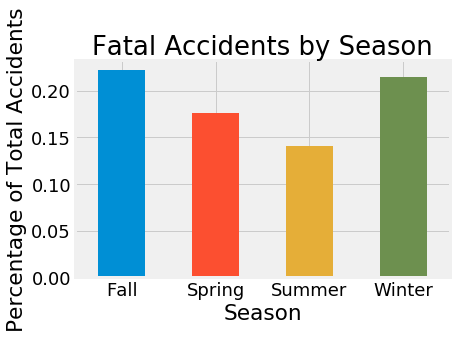

In [1336]:
relative_season_impact.plot.bar()
plt.xlabel('Season')
plt.ylabel('Percentage of Total Accidents')
plt.xticks(rotation=0)
plt.title("Fatal Accidents by Season")

## Fall and winter have the relatively highest fatal accidents!

In [1337]:
amatuer_build_impact = pd.value_counts(fatal_crash_df['Amateur_Built']) / pd.value_counts(real_df['Amateur_Built'])

Text(0.5,1,'Fatal Accidents by Amatuer Built')

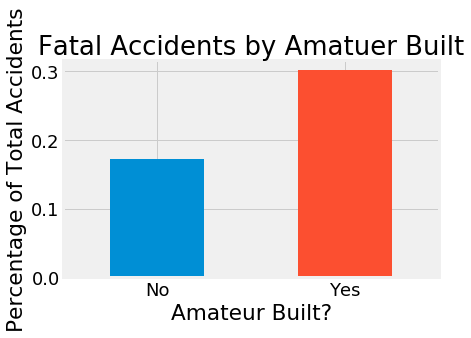

In [1338]:
amatuer_build_impact.plot.bar()
plt.xlabel('Amateur Built?')
plt.ylabel('Percentage of Total Accidents')
plt.xticks(rotation=0)
plt.title("Fatal Accidents by Amatuer Built")

In [1339]:
flight_purpose_impact = pd.value_counts(fatal_crash_df['Flight_Purpose']) / pd.value_counts(real_df['Flight_Purpose'])

Text(0.5,1,'Fatal Accidents by Flight Purpose')

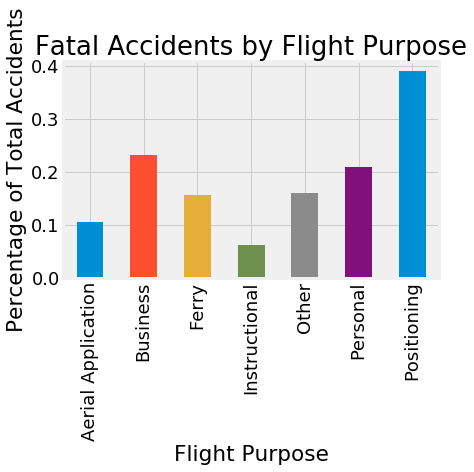

In [1340]:
flight_purpose_impact.plot.bar()
plt.xlabel('Flight Purpose')
plt.ylabel('Percentage of Total Accidents')
plt.xticks(rotation=90)
plt.title("Fatal Accidents by Flight Purpose")

In [1341]:
weather_impact = pd.value_counts(fatal_crash_df['Weather_Condition']) / pd.value_counts(real_df['Weather_Condition'])

Text(0.5,1,'Fatal Accidents by Weather Condition')

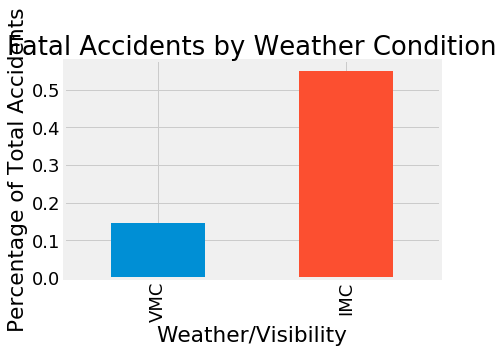

In [1342]:
weather_impact.plot.bar()
plt.xlabel('Weather/Visibility')
plt.ylabel('Percentage of Total Accidents')
plt.xticks(rotation=90)
plt.title("Fatal Accidents by Weather Condition")

In [1343]:
flight_phase_impact = pd.value_counts(fatal_crash_df['Broad_Phase_of_Flight']) / pd.value_counts(real_df['Broad_Phase_of_Flight'])

Text(0.5,1,'Fatal Accidents by flight phase')

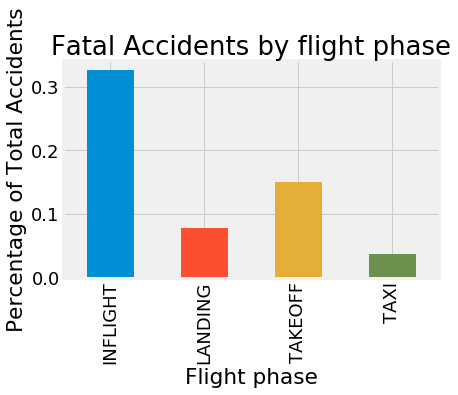

In [1344]:
flight_phase_impact.plot.bar()
plt.xlabel('Flight phase')
plt.ylabel('Percentage of Total Accidents')
plt.xticks(rotation=90)
plt.title("Fatal Accidents by flight phase")

In [1345]:
aircraft_category_impact = pd.value_counts(fatal_crash_df['Aircraft_Category']) / pd.value_counts(real_df['Aircraft_Category'])

Text(0.5,1,'Fatal Accidents by aircraft category')

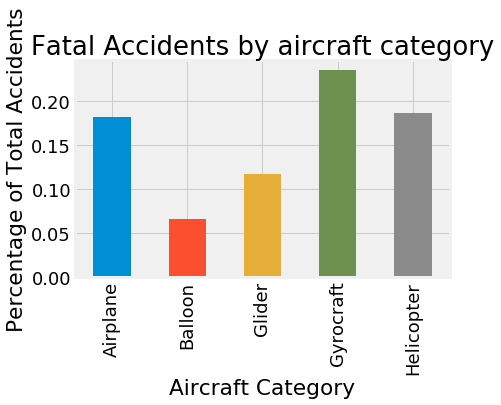

In [1346]:
aircraft_category_impact.plot.bar()
plt.xlabel('Aircraft Category')
plt.ylabel('Percentage of Total Accidents')
plt.xticks(rotation=90)
plt.title("Fatal Accidents by aircraft category")

In [1347]:
solo_flight_impact = pd.value_counts(fatal_crash_df['Solo_Flight']) / pd.value_counts(real_df['Solo_Flight'])

Text(0.5,1,'Fatal Accidents by solo flight')

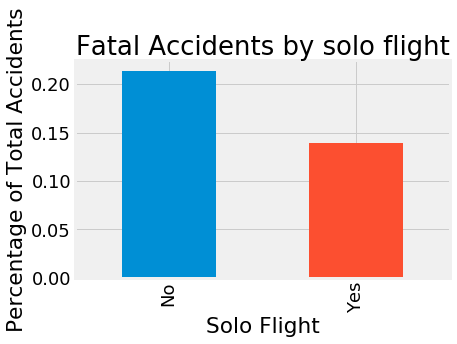

In [1348]:
solo_flight_impact.plot.bar()
plt.xlabel('Solo Flight')
plt.ylabel('Percentage of Total Accidents')
plt.xticks(rotation=90)
plt.title("Fatal Accidents by solo flight")

In [1349]:
commerical_flight_impact = pd.value_counts(fatal_crash_df['Commercial_Flight']) / pd.value_counts(real_df['Commercial_Flight'])

Text(0.5,1,'Fatal Accidents by commercial flight')

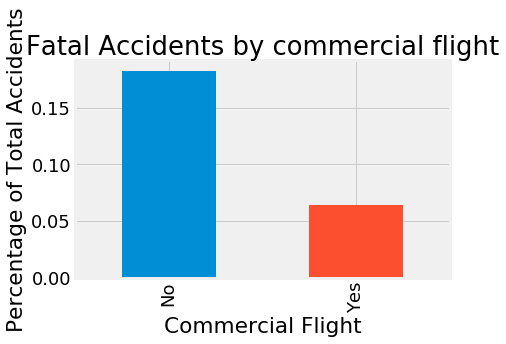

In [1350]:
commerical_flight_impact.plot.bar()
plt.xlabel('Commercial Flight')
plt.ylabel('Percentage of Total Accidents')
plt.xticks(rotation=90)
plt.title("Fatal Accidents by commercial flight")

In [1351]:
engine_type_impact = pd.value_counts(fatal_crash_df['Engine_Type']) / pd.value_counts(real_df['Engine_Type'])

Text(0.5,1,'Fatal Accidents by engine type')

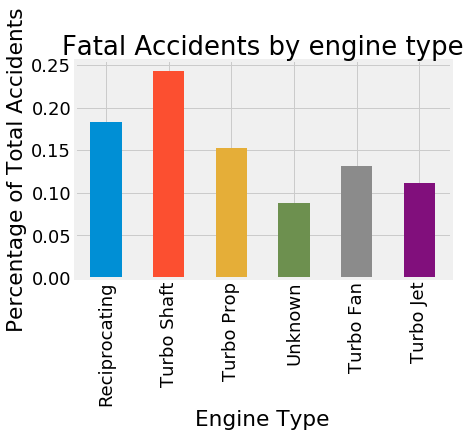

In [1352]:
engine_type_impact.plot.bar()
plt.xlabel('Engine Type')
plt.ylabel('Percentage of Total Accidents')
plt.xticks(rotation=90)
plt.title("Fatal Accidents by engine type")

In [1353]:
manufacturer_impact = pd.value_counts(fatal_crash_df['Major_manufacturer']) / pd.value_counts(real_df['Major_manufacturer'])

Text(0.5,1,'Fatal Accidents by major manufacturer')

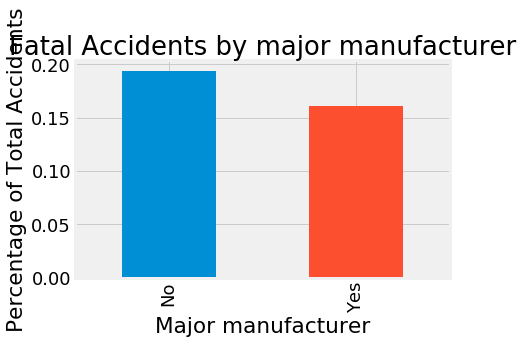

In [1354]:
manufacturer_impact.plot.bar()
plt.xlabel('Major manufacturer')
plt.ylabel('Percentage of Total Accidents')
plt.xticks(rotation=90)
plt.title("Fatal Accidents by major manufacturer")

In [1355]:
real_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3630 entries, 16185 to 81888
Data columns (total 26 columns):
Event_Id                  3630 non-null object
Investigation_Type        3630 non-null object
Event_Date                3630 non-null datetime64[ns]
Country                   3630 non-null object
Injury_Severity           3630 non-null object
Make                      3630 non-null object
Aircraft_Category         3630 non-null object
Amateur_Built             3630 non-null object
Number_Engines            3630 non-null float64
Engine_Type               3630 non-null object
Flight_Purpose            3630 non-null object
Total_Fatal_Injuries      3630 non-null float64
Total_Serious_Injuries    3630 non-null float64
Total_Minor_Injuries      3630 non-null float64
Total_Uninjured           3630 non-null float64
Weather_Condition         3630 non-null object
Broad_Phase_of_Flight     3630 non-null object
City                      3630 non-null object
State                     363

In [1356]:
dummy_df = real_df[['Season', 'Aircraft_Category', 'Amateur_Built', 'Engine_Type',
                    'Flight_Purpose', 'Weather_Condition', 'Broad_Phase_of_Flight',
                    'Solo_Flight', 'Major_manufacturer', 'Commercial_Flight']]

In [1357]:
dummy_df = pd.get_dummies(dummy_df)

In [1358]:
# dummy_df.reset_index(inplace=True)
# real_df.reset_index(inplace=True)

In [1359]:
dummy_df.head()

,Season_Fall,Season_Spring,Season_Summer,Season_Winter,Aircraft_Category_Airplane,Aircraft_Category_Balloon,Aircraft_Category_Glider,Aircraft_Category_Gyrocraft,Aircraft_Category_Helicopter,Amateur_Built_No,...,Broad_Phase_of_Flight_INFLIGHT,Broad_Phase_of_Flight_LANDING,Broad_Phase_of_Flight_TAKEOFF,Broad_Phase_of_Flight_TAXI,Solo_Flight_No,Solo_Flight_Yes,Major_manufacturer_No,Major_manufacturer_Yes,Commercial_Flight_No,Commercial_Flight_Yes
16185,1,0,0,0,1,0,0,0,0,1,...,1,0,0,0,1,0,1,0,1,0
16254,1,0,0,0,1,0,0,0,0,1,...,0,0,1,0,1,0,1,0,1,0
16315,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,1,0,1,0
16337,1,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,1,0,1,1,0
16369,1,0,0,0,0,0,0,0,1,1,...,1,0,0,0,0,1,1,0,1,0


In [1360]:
real_df.head()

,Event_Id,Investigation_Type,Event_Date,Country,Injury_Severity,Make,Aircraft_Category,Amateur_Built,Number_Engines,Engine_Type,...,Broad_Phase_of_Flight,City,State,Total_Passengers,Major_manufacturer,Solo_Flight,Commercial_Flight,Was_Fatal,Month,Season
16185,20081126X30503,Accident,2008-11-25,United States,Non-Fatal,PIPER,Airplane,No,1.0,Reciprocating,...,INFLIGHT,Monterey,CA,2.0,No,No,No,Non-fatal,11,Fall
16254,20081112X43029,Accident,2008-11-08,United States,Non-Fatal,PIPER,Airplane,No,1.0,Reciprocating,...,TAKEOFF,Nacogdoches,TX,2.0,No,No,No,Non-fatal,11,Fall
16315,20081024X13647,Accident,2008-10-24,United States,Non-Fatal,RANS,Airplane,Yes,1.0,Reciprocating,...,INFLIGHT,Breckenridge,TX,2.0,No,No,No,Non-fatal,10,Fall
16337,20081020X12359,Accident,2008-10-19,United States,Non-Fatal,CESSNA,Airplane,No,1.0,Reciprocating,...,LANDING,Angleton,TX,1.0,Yes,Yes,No,Non-fatal,10,Fall
16369,20081012X91435,Accident,2008-10-10,United States,Non-Fatal,BELL,Helicopter,No,1.0,Turbo Shaft,...,INFLIGHT,Cougar,WA,1.0,No,Yes,No,Non-fatal,10,Fall


In [1361]:
real_df = real_df.join(dummy_df)

In [1362]:
real_df.head()

,Event_Id,Investigation_Type,Event_Date,Country,Injury_Severity,Make,Aircraft_Category,Amateur_Built,Number_Engines,Engine_Type,...,Broad_Phase_of_Flight_INFLIGHT,Broad_Phase_of_Flight_LANDING,Broad_Phase_of_Flight_TAKEOFF,Broad_Phase_of_Flight_TAXI,Solo_Flight_No,Solo_Flight_Yes,Major_manufacturer_No,Major_manufacturer_Yes,Commercial_Flight_No,Commercial_Flight_Yes
16185,20081126X30503,Accident,2008-11-25,United States,Non-Fatal,PIPER,Airplane,No,1.0,Reciprocating,...,1,0,0,0,1,0,1,0,1,0
16254,20081112X43029,Accident,2008-11-08,United States,Non-Fatal,PIPER,Airplane,No,1.0,Reciprocating,...,0,0,1,0,1,0,1,0,1,0
16315,20081024X13647,Accident,2008-10-24,United States,Non-Fatal,RANS,Airplane,Yes,1.0,Reciprocating,...,1,0,0,0,1,0,1,0,1,0
16337,20081020X12359,Accident,2008-10-19,United States,Non-Fatal,CESSNA,Airplane,No,1.0,Reciprocating,...,0,1,0,0,0,1,0,1,1,0
16369,20081012X91435,Accident,2008-10-10,United States,Non-Fatal,BELL,Helicopter,No,1.0,Turbo Shaft,...,1,0,0,0,0,1,1,0,1,0


In [1363]:
real_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3630 entries, 16185 to 81888
Data columns (total 62 columns):
Event_Id                             3630 non-null object
Investigation_Type                   3630 non-null object
Event_Date                           3630 non-null datetime64[ns]
Country                              3630 non-null object
Injury_Severity                      3630 non-null object
Make                                 3630 non-null object
Aircraft_Category                    3630 non-null object
Amateur_Built                        3630 non-null object
Number_Engines                       3630 non-null float64
Engine_Type                          3630 non-null object
Flight_Purpose                       3630 non-null object
Total_Fatal_Injuries                 3630 non-null float64
Total_Serious_Injuries               3630 non-null float64
Total_Minor_Injuries                 3630 non-null float64
Total_Uninjured                      3630 non-null float64
Weath

In [1364]:
real_df.columns

Index(['Event_Id', 'Investigation_Type', 'Event_Date', 'Country',
       'Injury_Severity', 'Make', 'Aircraft_Category', 'Amateur_Built',
       'Number_Engines', 'Engine_Type', 'Flight_Purpose',
       'Total_Fatal_Injuries', 'Total_Serious_Injuries',
       'Total_Minor_Injuries', 'Total_Uninjured', 'Weather_Condition',
       'Broad_Phase_of_Flight', 'City', 'State', 'Total_Passengers',
       'Major_manufacturer', 'Solo_Flight', 'Commercial_Flight', 'Was_Fatal',
       'Month', 'Season', 'Season_Fall', 'Season_Spring', 'Season_Summer',
       'Season_Winter', 'Aircraft_Category_Airplane',
       'Aircraft_Category_Balloon', 'Aircraft_Category_Glider',
       'Aircraft_Category_Gyrocraft', 'Aircraft_Category_Helicopter',
       'Amateur_Built_No', 'Amateur_Built_Yes', 'Engine_Type_Reciprocating',
       'Engine_Type_Turbo Fan', 'Engine_Type_Turbo Jet',
       'Engine_Type_Turbo Prop', 'Engine_Type_Turbo Shaft',
       'Engine_Type_Unknown', 'Flight_Purpose_Aerial Application',
     

In [1147]:
target_count = real_df['Was_Fatal'].value_counts()
print(f'Non-Fatal: {target_count[0]}')
print(f'Fatal: {target_count[1]}')
print(f'Proportion: {round(target_count[0] / target_count[1], 2)} : 1')
print(f'Percentage of Majority Class: {round(target_count[0] / sum(target_count), 4)*100}')

Non-Fatal: 2971
Fatal: 659
Proportion: 4.51 : 1
Percentage of Majority Class: 81.85


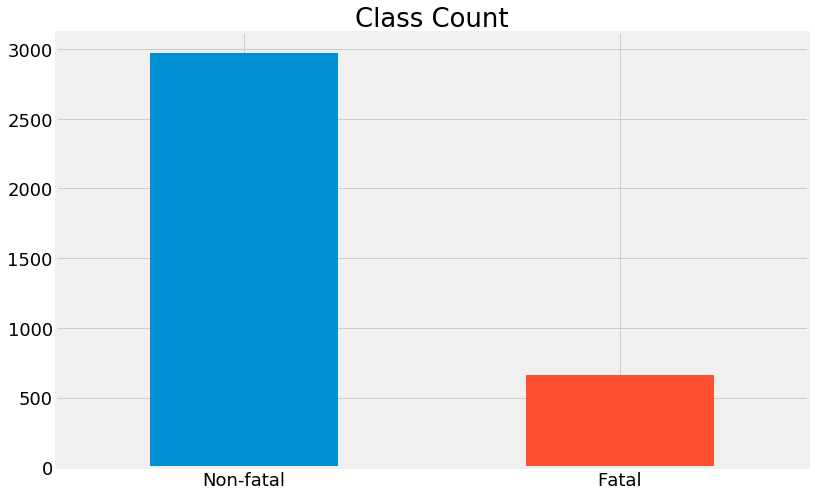

In [1148]:
target_count.plot(kind='bar', title='Class Count', rot=0);
plt.gcf().set_size_inches(12,8)

In [1149]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

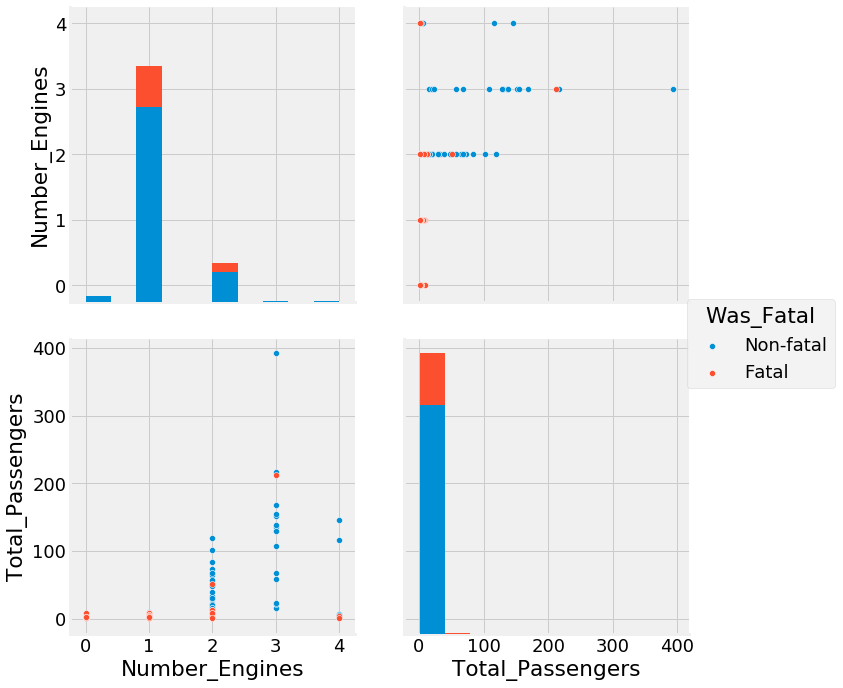

In [1150]:
numerical_df = real_df[['Number_Engines','Total_Passengers','Was_Fatal']]

sns.pairplot(numerical_df, hue='Was_Fatal', size=5);

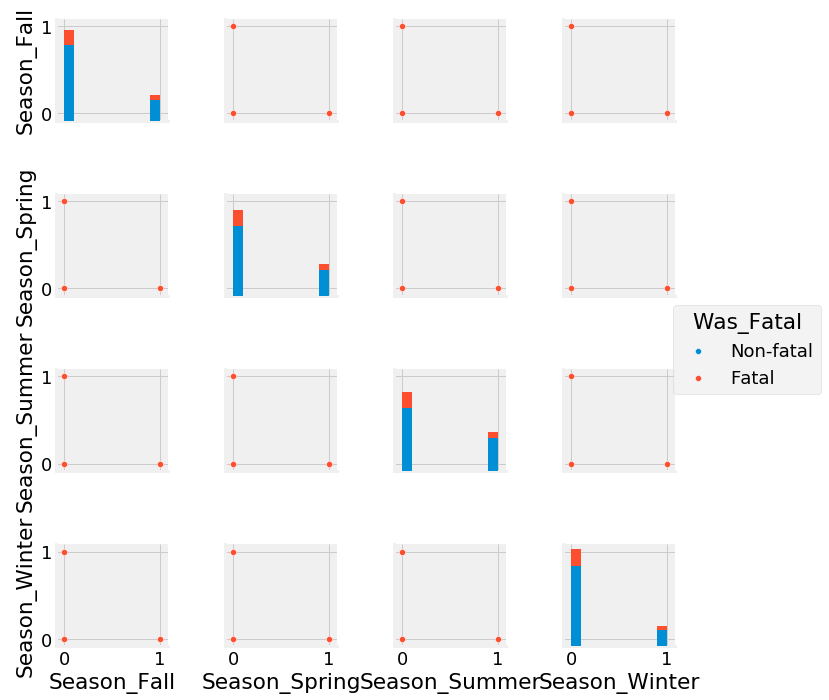

In [1151]:
season_df = real_df[['Was_Fatal','Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter']]

sns.pairplot(season_df, hue='Was_Fatal');

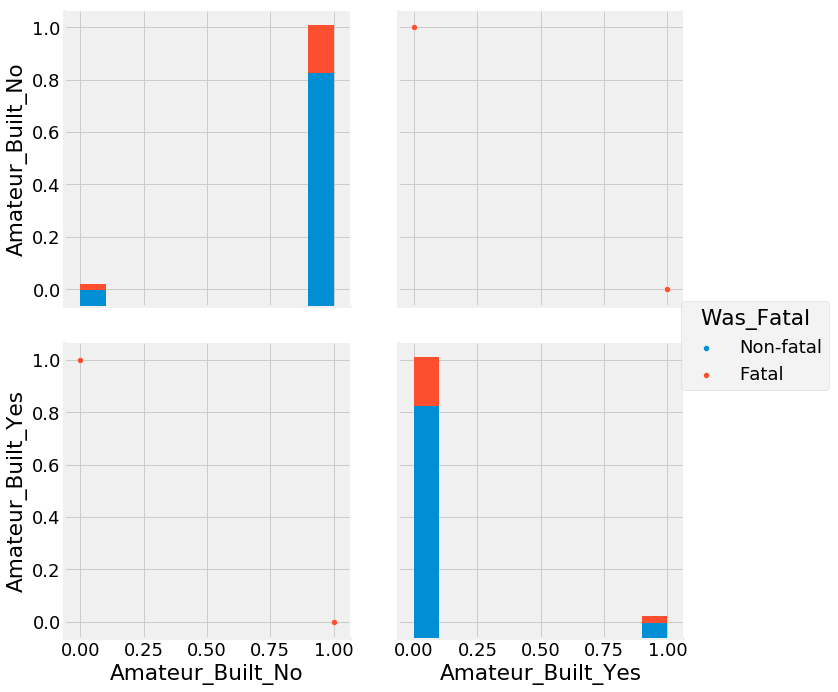

In [1152]:
amateur_df = real_df[['Was_Fatal','Amateur_Built_No', 'Amateur_Built_Yes']]

sns.pairplot(amateur_df, hue='Was_Fatal', size=5);

# END OF EDA / START OF ANALYSIS

In [772]:
y = real_df['Was_Fatal']
X = real_df[['Number_Engines','Total_Passengers', 'Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Aircraft_Category_Airplane', 'Aircraft_Category_Balloon',
       'Aircraft_Category_Glider', 'Aircraft_Category_Gyrocraft',
       'Aircraft_Category_Helicopter', 'Amateur_Built_No', 'Amateur_Built_Yes',
       'Engine_Type_Reciprocating', 'Engine_Type_Turbo Fan',
       'Engine_Type_Turbo Jet', 'Engine_Type_Turbo Prop',
       'Engine_Type_Turbo Shaft', 'Engine_Type_Unknown',
       'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI',
       'Solo_Flight_No', 'Solo_Flight_Yes']]


X_train, X_FINALtest, y_train, y_FINALtest = train_test_split(X, y, test_size=0.25, random_state=4444, stratify=y)

In [773]:
X_train.head()

,Number_Engines,Total_Passengers,Season_Fall,Season_Spring,Season_Summer,Season_Winter,Aircraft_Category_Airplane,Aircraft_Category_Balloon,Aircraft_Category_Glider,Aircraft_Category_Gyrocraft,...,Flight_Purpose_Personal,Flight_Purpose_Positioning,Weather_Condition_IMC,Weather_Condition_VMC,Broad_Phase_of_Flight_INFLIGHT,Broad_Phase_of_Flight_LANDING,Broad_Phase_of_Flight_TAKEOFF,Broad_Phase_of_Flight_TAXI,Solo_Flight_No,Solo_Flight_Yes
81228,2.0,1.0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,1
78990,1.0,4.0,1,0,0,0,1,0,0,0,...,1,0,0,1,0,1,0,0,1,0
80681,1.0,1.0,0,1,0,0,1,0,0,0,...,1,0,0,1,0,1,0,0,0,1
80265,0.0,3.0,0,0,1,0,0,1,0,0,...,1,0,0,1,0,1,0,0,1,0
78806,1.0,2.0,1,0,0,0,1,0,0,0,...,1,0,0,1,0,1,0,0,1,0


In [774]:
ssX = StandardScaler()
X_train_scalable = X_train.filter(['Number_Engines','Total_Passengers'], axis=1)
X_train_scaled_columns = pd.DataFrame(ssX.fit_transform(X_train_scalable), columns = ['Number_Engines_Scaled','Total_Passengers_Scaled'])

X_train.reset_index(inplace=True)
X_train = X_train.join(X_train_scaled_columns)
X_train = X_train.drop(['Number_Engines','Total_Passengers'],1)

X_train = X_train.set_index('index')

X_test_scalable = X_FINALtest.filter(['Number_Engines','Total_Passengers'], axis=1)
X_test_scaled_columns = pd.DataFrame(ssX.transform(X_test_scalable), columns = ['Number_Engines_Scaled','Total_Passengers_Scaled'])

X_FINALtest.reset_index(inplace=True)
X_FINALtest = X_FINALtest.join(X_test_scaled_columns)
X_FINALtest = X_FINALtest.drop(['Number_Engines','Total_Passengers'],1)

X_FINALtest = X_FINALtest.set_index('index')

In [775]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2727 entries, 81228 to 81672
Data columns (total 34 columns):
Season_Fall                          2727 non-null uint8
Season_Spring                        2727 non-null uint8
Season_Summer                        2727 non-null uint8
Season_Winter                        2727 non-null uint8
Aircraft_Category_Airplane           2727 non-null uint8
Aircraft_Category_Balloon            2727 non-null uint8
Aircraft_Category_Glider             2727 non-null uint8
Aircraft_Category_Gyrocraft          2727 non-null uint8
Aircraft_Category_Helicopter         2727 non-null uint8
Amateur_Built_No                     2727 non-null uint8
Amateur_Built_Yes                    2727 non-null uint8
Engine_Type_Reciprocating            2727 non-null uint8
Engine_Type_Turbo Fan                2727 non-null uint8
Engine_Type_Turbo Jet                2727 non-null uint8
Engine_Type_Turbo Prop               2727 non-null uint8
Engine_Type_Turbo Shaft          

In [776]:
X_FINALtest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 909 entries, 80468 to 78807
Data columns (total 34 columns):
Season_Fall                          909 non-null uint8
Season_Spring                        909 non-null uint8
Season_Summer                        909 non-null uint8
Season_Winter                        909 non-null uint8
Aircraft_Category_Airplane           909 non-null uint8
Aircraft_Category_Balloon            909 non-null uint8
Aircraft_Category_Glider             909 non-null uint8
Aircraft_Category_Gyrocraft          909 non-null uint8
Aircraft_Category_Helicopter         909 non-null uint8
Amateur_Built_No                     909 non-null uint8
Amateur_Built_Yes                    909 non-null uint8
Engine_Type_Reciprocating            909 non-null uint8
Engine_Type_Turbo Fan                909 non-null uint8
Engine_Type_Turbo Jet                909 non-null uint8
Engine_Type_Turbo Prop               909 non-null uint8
Engine_Type_Turbo Shaft              909 non-null

In [777]:
## THIS IS JUST USING DEFAULTS FOR EACH TYPE -- NEED TO TUNE HYPERPARAMETERS

X_temptrain, X_temptest, y_temptrain, y_temptest = train_test_split(X_train, y_train, test_size=0.3, random_state=4444)

models = [LogisticRegression(), KNeighborsClassifier(), GaussianNB(), SVC(),
           DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]
names = ['LR', 'KNN', 'NB', 'SVC', 'Decision Tree', 'Random Forest', 'Gradient Boosted Trees']

for i in range(len(models)):    
    models[i].fit(X_temptrain, y_temptrain)
    y_predict = models[i].predict(X_temptest)
    accuracy = np.round(accuracy_score(y_temptest, y_predict), 4)
    precision = np.round(precision_score(y_temptest, y_predict, pos_label = 'Fatal'), 4)
    recall = np.round(recall_score(y_temptest, y_predict, pos_label = 'Fatal'), 4)
    f1 = np.round(f1_score(y_temptest, y_predict, pos_label = 'Fatal'), 4)
    print(f'{names[i]} acc: {accuracy} prec: {precision} recall: {recall} f1-score: {f1}')
    print('')

LR acc: 0.8425 prec: 0.5818 recall: 0.2319 f1-score: 0.3316

KNN acc: 0.8278 prec: 0.4789 recall: 0.2464 f1-score: 0.3254

NB acc: 0.7668 prec: 0.3732 recall: 0.5652 f1-score: 0.4496

SVC acc: 0.8413 prec: 0.5588 recall: 0.2754 f1-score: 0.3689

Decision Tree acc: 0.7851 prec: 0.339 recall: 0.2899 f1-score: 0.3125

Random Forest acc: 0.8046 prec: 0.369 recall: 0.2246 f1-score: 0.2793

Gradient Boosted Trees acc: 0.8462 prec: 0.5909 recall: 0.2826 f1-score: 0.3824



In [778]:
## FROM DAMIEN'S PAIR PROGRAMMING EXAMPLE

models = [('knn', KNeighborsClassifier), 
          ('logistic', LogisticRegression),
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier)
         ]

param_choices = [
    {
        'n_neighbors': range(1, 12)
    },
    {
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    }
]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_train, y_train)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

knn: best score: 0.8247158049138247, best estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=11, p=2,
           weights='uniform')
logistic: best score: 0.8346167950128346, best estimator: LogisticRegression(C=0.2848035868435802, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
tree: best score: 0.8291162449578291, best estimator: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
forest: best score: 0.8338833883388339, bes

In [779]:
from sklearn.feature_selection import SelectKBest, RFE, chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA

def feature_selection(X, y, count):

    # Feature Importance from Random Forest
    ET = ExtraTreesClassifier()
    ET.fit(X, y)    
    importances = list(zip(ET.feature_importances_, X.columns))
    importances.sort(reverse=True)
    FI_features = [x[1] for x in importances][0:count]
    
    # RANDOM FOREST FEATURE IMPORTANCE
    RF = RandomForestClassifier()
    RF.fit(X, y)    
    importances = list(zip(RF.feature_importances_, X.columns))
    importances.sort(reverse=True)
    RF_features = [x[1] for x in importances][0:count]

    # Recursive Feature Elimination
    lr = LogisticRegression()
    rfe = RFE(lr, count)
    fit = rfe.fit(X, y)
    RLR_features = list(X.columns[fit.support_])

    # PCA
#     pca = PCA(n_components=5)
#     fit = pca.fit(X)    
#     df = pd.DataFrame(pca.components_,columns=X.columns).abs().mean().sort_values(ascending = False)
#     PCA_features = list(df.index.values)[0:7]
    
    feats = pd.DataFrame(
        {
         'ExtraTrees FI': FI_features,
         'Recursive LogReg': RLR_features,
         'Random Forest FI': RF_features
#          'PCA': PCA_features
        })
    
    return feats

In [780]:
feature_selection(X_train, y_train, 20)

,ExtraTrees FI,Random Forest FI,Recursive LogReg
0,Total_Passengers_Scaled,Total_Passengers_Scaled,Season_Summer
1,Weather_Condition_VMC,Weather_Condition_VMC,Aircraft_Category_Helicopter
2,Broad_Phase_of_Flight_INFLIGHT,Broad_Phase_of_Flight_INFLIGHT,Amateur_Built_No
3,Number_Engines_Scaled,Weather_Condition_IMC,Amateur_Built_Yes
4,Weather_Condition_IMC,Number_Engines_Scaled,Engine_Type_Reciprocating
5,Broad_Phase_of_Flight_LANDING,Broad_Phase_of_Flight_LANDING,Engine_Type_Turbo Fan
6,Flight_Purpose_Personal,Flight_Purpose_Other,Engine_Type_Turbo Prop
7,Flight_Purpose_Other,Flight_Purpose_Personal,Engine_Type_Turbo Shaft
8,Season_Fall,Flight_Purpose_Business,Engine_Type_Unknown
9,Season_Summer,Season_Fall,Flight_Purpose_Aerial Application


In [781]:
models = [('logistic', LogisticRegression)]

param_choices = [{
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_train, y_train)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

logistic: best score: 0.8346167950128346, best estimator: LogisticRegression(C=0.2848035868435802, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [782]:
lm1 = grid.best_estimator_
lm1.fit(X_train, y_train)

LogisticRegression(C=0.2848035868435802, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [783]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []
    
for train_index, test_index in kf.split(X_train):

    kX_train = X_train.iloc[train_index]
    kX_test = X_train.iloc[test_index]
    ky_train = y_train.iloc[train_index]
    ky_test = y_train.iloc[test_index]

    lm1.fit(kX_train, ky_train)
    y_predict = lm1.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print('Scores with Unbalanced Data -- Logistic Regress MVP')
print(f'Logistic Regress accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

Scores with Unbalanced Data -- Logistic Regress MVP
Logistic Regress accuracy: 0.8335 precision: 0.628 recall: 0.2103 f1: 0.3144 fB: 0.2424



In [784]:
columns = ['Number_Engines_Scaled','Total_Passengers_Scaled', 'Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Aircraft_Category_Airplane', 'Aircraft_Category_Balloon',
       'Aircraft_Category_Glider', 'Aircraft_Category_Gyrocraft',
       'Aircraft_Category_Helicopter', 'Amateur_Built_No', 'Amateur_Built_Yes',
       'Engine_Type_Reciprocating', 'Engine_Type_Turbo Fan',
       'Engine_Type_Turbo Jet', 'Engine_Type_Turbo Prop',
       'Engine_Type_Turbo Shaft', 'Engine_Type_Unknown',
       'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI',
       'Solo_Flight_No', 'Solo_Flight_Yes']

coef_viewer = {}
for col, score in zip(columns, lm1.coef_[0]):
    coef_viewer[col] = score
pd.Series(coef_viewer)

Aircraft_Category_Airplane           0.027113
Aircraft_Category_Balloon            0.196349
Aircraft_Category_Glider             0.142733
Aircraft_Category_Gyrocraft          0.571198
Aircraft_Category_Helicopter        -0.199186
Amateur_Built_No                    -0.246682
Amateur_Built_Yes                    0.206077
Broad_Phase_of_Flight_INFLIGHT      -0.149821
Broad_Phase_of_Flight_LANDING        0.638868
Broad_Phase_of_Flight_TAKEOFF       -0.117868
Broad_Phase_of_Flight_TAXI           0.489879
Engine_Type_Reciprocating            0.288537
Engine_Type_Turbo Fan                0.355335
Engine_Type_Turbo Jet               -0.300396
Engine_Type_Turbo Prop               0.069141
Engine_Type_Turbo Shaft              0.491260
Engine_Type_Unknown                 -0.066162
Flight_Purpose_Aerial Application   -0.120253
Flight_Purpose_Business              0.407276
Flight_Purpose_Ferry                 0.322874
Flight_Purpose_Instructional        -0.217031
Flight_Purpose_Other              

In [785]:
models = [('forest', RandomForestClassifier)]

param_choices = [{
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_train, y_train)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

forest: best score: 0.8342500916758343, best estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [786]:
rf = grid.best_estimator_
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [787]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []
    
for train_index, test_index in kf.split(X_train):

    kX_train = X_train.iloc[train_index]
    kX_test = X_train.iloc[test_index]
    ky_train = y_train.iloc[train_index]
    ky_test = y_train.iloc[test_index]

    lm1.fit(kX_train, ky_train)
    y_predict = rf.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print('Scores with Unbalanced Data -- RF MVP')
print(f'RF MVP accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

Scores with Unbalanced Data -- RF MVP
RF MVP accuracy: 0.8365 precision: 0.7064 recall: 0.1707 f1: 0.2747 fB: 0.2012



In [788]:
columns = ['Number_Engines_Scaled','Total_Passengers_Scaled', 'Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Aircraft_Category_Airplane', 'Aircraft_Category_Balloon',
       'Aircraft_Category_Glider', 'Aircraft_Category_Gyrocraft',
       'Aircraft_Category_Helicopter', 'Amateur_Built_No', 'Amateur_Built_Yes',
       'Engine_Type_Reciprocating', 'Engine_Type_Turbo Fan',
       'Engine_Type_Turbo Jet', 'Engine_Type_Turbo Prop',
       'Engine_Type_Turbo Shaft', 'Engine_Type_Unknown',
       'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI',
       'Solo_Flight_No', 'Solo_Flight_Yes']

feature_viewer = {}
for col, score in zip(columns, rf.feature_importances_):
    feature_viewer[col] = score
pd.Series(feature_viewer)

Aircraft_Category_Airplane           0.000201
Aircraft_Category_Balloon            0.000208
Aircraft_Category_Glider             0.003275
Aircraft_Category_Gyrocraft          0.021723
Aircraft_Category_Helicopter         0.021270
Amateur_Built_No                     0.005805
Amateur_Built_Yes                    0.001623
Broad_Phase_of_Flight_INFLIGHT       0.015955
Broad_Phase_of_Flight_LANDING        0.006242
Broad_Phase_of_Flight_TAKEOFF        0.021157
Broad_Phase_of_Flight_TAXI           0.028603
Engine_Type_Reciprocating            0.000124
Engine_Type_Turbo Fan                0.002421
Engine_Type_Turbo Jet                0.002222
Engine_Type_Turbo Prop               0.002606
Engine_Type_Turbo Shaft              0.005212
Engine_Type_Unknown                  0.011020
Flight_Purpose_Aerial Application    0.000910
Flight_Purpose_Business              0.014468
Flight_Purpose_Ferry                 0.015715
Flight_Purpose_Instructional         0.017138
Flight_Purpose_Other              

In [789]:
beta = np.linspace(1, 2, 10)

param_grid = dict(beta=beta)
print(param_grid)

{'beta': array([1.        , 1.11111111, 1.22222222, 1.33333333, 1.44444444,
       1.55555556, 1.66666667, 1.77777778, 1.88888889, 2.        ])}


In [790]:
from sklearn.metrics import fbeta_score

for b in beta:
    kf = KFold(random_state = 4444)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    fB = []

    y_predict = rf.predict(X_FINALtest)

    accuracy.append(accuracy_score(y_FINALtest, y_predict))
    precision.append(precision_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(y_FINALtest, y_predict, beta=b, pos_label = 'Fatal'))

    accuracy = np.round(np.mean(accuracy), 4)
    precision = np.round(np.mean(precision), 4)
    recall = np.round(np.mean(recall), 4)
    f1 = np.round(np.mean(f1), 4)
    fB = np.round(np.mean(fB), 4)

    print(f'TEST Scores with unbalanced RF -- beta: {b}')
    print(f'accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
    print('')

TEST Scores with unbalanced RF -- beta: 1.0
accuracy: 0.835 precision: 0.6829 recall: 0.1697 f1: 0.2718 fB: 0.2718

TEST Scores with unbalanced RF -- beta: 1.1111111111111112
accuracy: 0.835 precision: 0.6829 recall: 0.1697 f1: 0.2718 fB: 0.2557

TEST Scores with unbalanced RF -- beta: 1.2222222222222223
accuracy: 0.835 precision: 0.6829 recall: 0.1697 f1: 0.2718 fB: 0.2429

TEST Scores with unbalanced RF -- beta: 1.3333333333333333
accuracy: 0.835 precision: 0.6829 recall: 0.1697 f1: 0.2718 fB: 0.2326

TEST Scores with unbalanced RF -- beta: 1.4444444444444444
accuracy: 0.835 precision: 0.6829 recall: 0.1697 f1: 0.2718 fB: 0.2243

TEST Scores with unbalanced RF -- beta: 1.5555555555555556
accuracy: 0.835 precision: 0.6829 recall: 0.1697 f1: 0.2718 fB: 0.2175

TEST Scores with unbalanced RF -- beta: 1.6666666666666665
accuracy: 0.835 precision: 0.6829 recall: 0.1697 f1: 0.2718 fB: 0.2118

TEST Scores with unbalanced RF -- beta: 1.7777777777777777
accuracy: 0.835 precision: 0.6829 recal

## MVP WITH SMOTE

In [791]:
from imblearn.over_sampling import SMOTE
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X_train,y_train)

X_smoted = pd.DataFrame(X_smoted, columns=['Number_Engines_Scaled','Total_Passengers_Scaled', 'Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Aircraft_Category_Airplane', 'Aircraft_Category_Balloon',
       'Aircraft_Category_Glider', 'Aircraft_Category_Gyrocraft',
       'Aircraft_Category_Helicopter', 'Amateur_Built_No', 'Amateur_Built_Yes',
       'Engine_Type_Reciprocating', 'Engine_Type_Turbo Fan',
       'Engine_Type_Turbo Jet', 'Engine_Type_Turbo Prop',
       'Engine_Type_Turbo Shaft', 'Engine_Type_Unknown',
       'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI',
       'Solo_Flight_No', 'Solo_Flight_Yes'])

y_smoted = pd.Series(y_smoted)

In [792]:
# USING SMOTE

models = [LogisticRegression(), KNeighborsClassifier(), GaussianNB(), SVC(),
           DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]
names = ['LR', 'KNN', 'NB', 'SVC', 'Decision Tree', 'Random Forest', 'Gradient Boosted Trees']

for i in range(len(models)):
    
    kf = KFold(random_state = 4444)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    fB = []
    
    for train_index, test_index in kf.split(X_smoted):
        
        kX_train = X_smoted.iloc[train_index]
        kX_test = X_smoted.iloc[test_index]
        ky_train = y_smoted.iloc[train_index]
        ky_test = y_smoted.iloc[test_index]
        
        models[i].fit(kX_train, ky_train)
        y_predict = models[i].predict(kX_test)
        
        accuracy.append(accuracy_score(ky_test, y_predict))
        precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
        recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
        f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
        fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))
    
    accuracy = np.round(np.mean(accuracy), 4)
    precision = np.round(np.mean(precision), 4)
    recall = np.round(np.mean(recall), 4)
    f1 = np.round(np.mean(f1), 4)
    fB = np.round(np.mean(fB), 4)
    
    print('Scores with SMOTE Oversampling')
    print(f'{names[i]} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
    print('')

Scores with SMOTE Oversampling
LR accuracy: 0.5163 precision: 0.5927 recall: 0.6553 f1: 0.4955 fB: 0.5547

Scores with SMOTE Oversampling
KNN accuracy: 0.6297 precision: 0.6286 recall: 0.638 f1: 0.5731 fB: 0.5962

Scores with SMOTE Oversampling
NB accuracy: 0.5895 precision: 0.534 recall: 0.8719 f1: 0.6 fB: 0.7053

Scores with SMOTE Oversampling
SVC accuracy: 0.483 precision: 0.5811 recall: 0.6577 f1: 0.47 fB: 0.5403

Scores with SMOTE Oversampling
Decision Tree accuracy: 0.714 precision: 0.6407 recall: 0.7267 f1: 0.647 fB: 0.6827

Scores with SMOTE Oversampling
Random Forest accuracy: 0.7138 precision: 0.658 recall: 0.7335 f1: 0.6558 fB: 0.6899

Scores with SMOTE Oversampling
Gradient Boosted Trees accuracy: 0.7055 precision: 0.6731 recall: 0.7026 f1: 0.6477 fB: 0.6694



In [793]:
models = [('forest', RandomForestClassifier)]

param_choices = [{
        'n_estimators': [25,50, 100, 200],
        'max_depth': [1,2,3,4,5,7,10],
        'min_samples_leaf': [3,6,10]
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_smoted, y_smoted)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

forest: best score: 0.7982967279246974, best estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [794]:
rf2 = grid.best_estimator_
rf2.fit(X_smoted, y_smoted)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [795]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []
    
for train_index, test_index in kf.split(X_smoted):

    kX_train = X_smoted.iloc[train_index]
    kX_test = X_smoted.iloc[test_index]
    ky_train = y_smoted.iloc[train_index]
    ky_test = y_smoted.iloc[test_index]

    lm1.fit(kX_train, ky_train)
    y_predict = rf2.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print('Scores with SMOTE Oversampling -- RF SMOTED MVP')
print(f'RF MVP accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

Scores with SMOTE Oversampling -- RF SMOTED MVP
RF MVP accuracy: 0.8223 precision: 0.6942 recall: 0.7902 f1: 0.7279 fB: 0.7605



In [796]:
feature_selection(X_smoted, y_smoted, 20)

,ExtraTrees FI,Random Forest FI,Recursive LogReg
0,Solo_Flight_Yes,Weather_Condition_IMC,Aircraft_Category_Gyrocraft
1,Weather_Condition_IMC,Solo_Flight_Yes,Aircraft_Category_Helicopter
2,Weather_Condition_VMC,Flight_Purpose_Instructional,Amateur_Built_No
3,Flight_Purpose_Personal,Weather_Condition_VMC,Amateur_Built_Yes
4,Flight_Purpose_Instructional,Flight_Purpose_Positioning,Engine_Type_Reciprocating
5,Flight_Purpose_Positioning,Flight_Purpose_Personal,Engine_Type_Turbo Jet
6,Solo_Flight_No,Flight_Purpose_Ferry,Engine_Type_Turbo Prop
7,Flight_Purpose_Ferry,Flight_Purpose_Business,Engine_Type_Turbo Shaft
8,Season_Fall,Solo_Flight_No,Engine_Type_Unknown
9,Flight_Purpose_Business,Number_Engines_Scaled,Flight_Purpose_Business


In [797]:
columns = ['Number_Engines_Scaled','Total_Passengers_Scaled', 'Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Aircraft_Category_Airplane', 'Aircraft_Category_Balloon',
       'Aircraft_Category_Glider', 'Aircraft_Category_Gyrocraft',
       'Aircraft_Category_Helicopter', 'Amateur_Built_No', 'Amateur_Built_Yes',
       'Engine_Type_Reciprocating', 'Engine_Type_Turbo Fan',
       'Engine_Type_Turbo Jet', 'Engine_Type_Turbo Prop',
       'Engine_Type_Turbo Shaft', 'Engine_Type_Unknown',
       'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI',
       'Solo_Flight_No', 'Solo_Flight_Yes']

feature_viewer = {}
for col, score in zip(columns, rf2.feature_importances_):
    feature_viewer[col] = score
pd.Series(feature_viewer)

Aircraft_Category_Airplane           0.000921
Aircraft_Category_Balloon            0.001712
Aircraft_Category_Glider             0.012708
Aircraft_Category_Gyrocraft          0.018170
Aircraft_Category_Helicopter         0.014368
Amateur_Built_No                     0.012136
Amateur_Built_Yes                    0.002059
Broad_Phase_of_Flight_INFLIGHT       0.036338
Broad_Phase_of_Flight_LANDING        0.022489
Broad_Phase_of_Flight_TAKEOFF        0.017908
Broad_Phase_of_Flight_TAXI           0.016868
Engine_Type_Reciprocating            0.000634
Engine_Type_Turbo Fan                0.003922
Engine_Type_Turbo Jet                0.003203
Engine_Type_Turbo Prop               0.002478
Engine_Type_Turbo Shaft              0.018503
Engine_Type_Unknown                  0.019883
Flight_Purpose_Aerial Application    0.005714
Flight_Purpose_Business              0.038944
Flight_Purpose_Ferry                 0.030611
Flight_Purpose_Instructional         0.063940
Flight_Purpose_Other              

In [798]:
## FROM DAMIEN'S PAIR PROGRAMMING EXAMPLE

# models = [('knn', KNeighborsClassifier), 
#           ('logistic', LogisticRegression),
#           ('tree', DecisionTreeClassifier),
#           ('forest', RandomForestClassifier)
#          ]

# param_choices = [
#     {
#         'n_neighbors': range(1, 12)
#     },
#     {
#         'C': np.logspace(-3,6, 12),
#         'penalty': ['l1', 'l2']
#     },
#     {
#         'max_depth': [1,2,3,4,5],
#         'min_samples_leaf': [3,6,10]
#     },
#     {
#         'n_estimators': [50, 100, 200],
#         'max_depth': [1,2,3,4,5],
#         'min_samples_leaf': [3,6,10]
#     }
# ]

# grids = {}
# for model_info, params in zip(models, param_choices):
#     name, model = model_info
#     grid = GridSearchCV(model(), params)
#     grid.fit(X_smoted, y_smoted)
#     s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
#     print(s)
#     grids[name] = grid

In [799]:
from sklearn.metrics import fbeta_score

kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []

y_predict = rf2.predict(X_FINALtest)

accuracy.append(accuracy_score(y_FINALtest, y_predict))
precision.append(precision_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
recall.append(recall_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
f1.append(f1_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
fB.append(fbeta_score(y_FINALtest, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print(f'FINAL TEST SCORE with SMOTE Random Forest MVP')
print(f'accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

FINAL TEST SCORE with SMOTE Random Forest MVP
accuracy: 0.7866 precision: 0.4378 recall: 0.6182 f1: 0.5126 fB: 0.5711



In [800]:
models = [('tree', DecisionTreeClassifier)]

param_choices = [{
        'max_depth': [1,2,3,4,5,6,7],
        'min_samples_leaf': [3,6,8,10,12,15]
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_smoted, y_smoted)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

tree: best score: 0.7745405647691618, best estimator: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [801]:
dt = grid.best_estimator_
dt.fit(X_smoted, y_smoted)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [802]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []
    
for train_index, test_index in kf.split(X_smoted):

    kX_train = X_smoted.iloc[train_index]
    kX_test = X_smoted.iloc[test_index]
    ky_train = y_smoted.iloc[train_index]
    ky_test = y_smoted.iloc[test_index]

    lm1.fit(kX_train, ky_train)
    y_predict = dt.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print('Scores with SMOTE Oversampling -- Decision Tree SMOTED MVP')
print(f'RF MVP accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

Scores with SMOTE Oversampling -- Decision Tree SMOTED MVP
RF MVP accuracy: 0.7994 precision: 0.6742 recall: 0.7672 f1: 0.7046 fB: 0.737



In [803]:
from sklearn.metrics import fbeta_score

models = [dt, rf2]
names = ['Decision Tree SMOTE MVP', 'Random Forest SMOTE MVP']

for model, name in zip(models, names):

    kf = KFold(random_state = 4444)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    fB = []

    y_predict = model.predict(X_FINALtest)

    accuracy.append(accuracy_score(y_FINALtest, y_predict))
    precision.append(precision_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(y_FINALtest, y_predict, beta=2.0, pos_label = 'Fatal'))

    accuracy = np.round(np.mean(accuracy), 4)
    precision = np.round(np.mean(precision), 4)
    recall = np.round(np.mean(recall), 4)
    f1 = np.round(np.mean(f1), 4)
    fB = np.round(np.mean(fB), 4)

    print(f'FINAL TEST Scores MVP')
    print(f'{name} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
    print('')

FINAL TEST Scores MVP
Decision Tree SMOTE MVP accuracy: 0.7613 precision: 0.3984 recall: 0.6182 f1: 0.4846 fB: 0.5568

FINAL TEST Scores MVP
Random Forest SMOTE MVP accuracy: 0.7866 precision: 0.4378 recall: 0.6182 f1: 0.5126 fB: 0.5711



In [804]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc

models = [dt, rf2]
names = ['Decision Tree SMOTE MVP', 'Random Forest SMOTE MVP']

roc_plotting_stuff = []
for model, name in zip(models, names):
    model.fit(X_smoted, y_smoted)
    preds = model.predict_proba(X_FINALtest)
    fpr, tpr, _ = roc_curve(y_FINALtest, preds[:,0], pos_label = 'Fatal')
    auc_score = auc(fpr, tpr)
    roc_plotting_stuff.append((name, tpr, fpr, auc_score))
    
print(preds)

[[0.19590161 0.80409839]
 [0.67742635 0.32257365]
 [0.18372312 0.81627688]
 ...
 [0.65087657 0.34912343]
 [0.45128822 0.54871178]
 [0.28242271 0.71757729]]


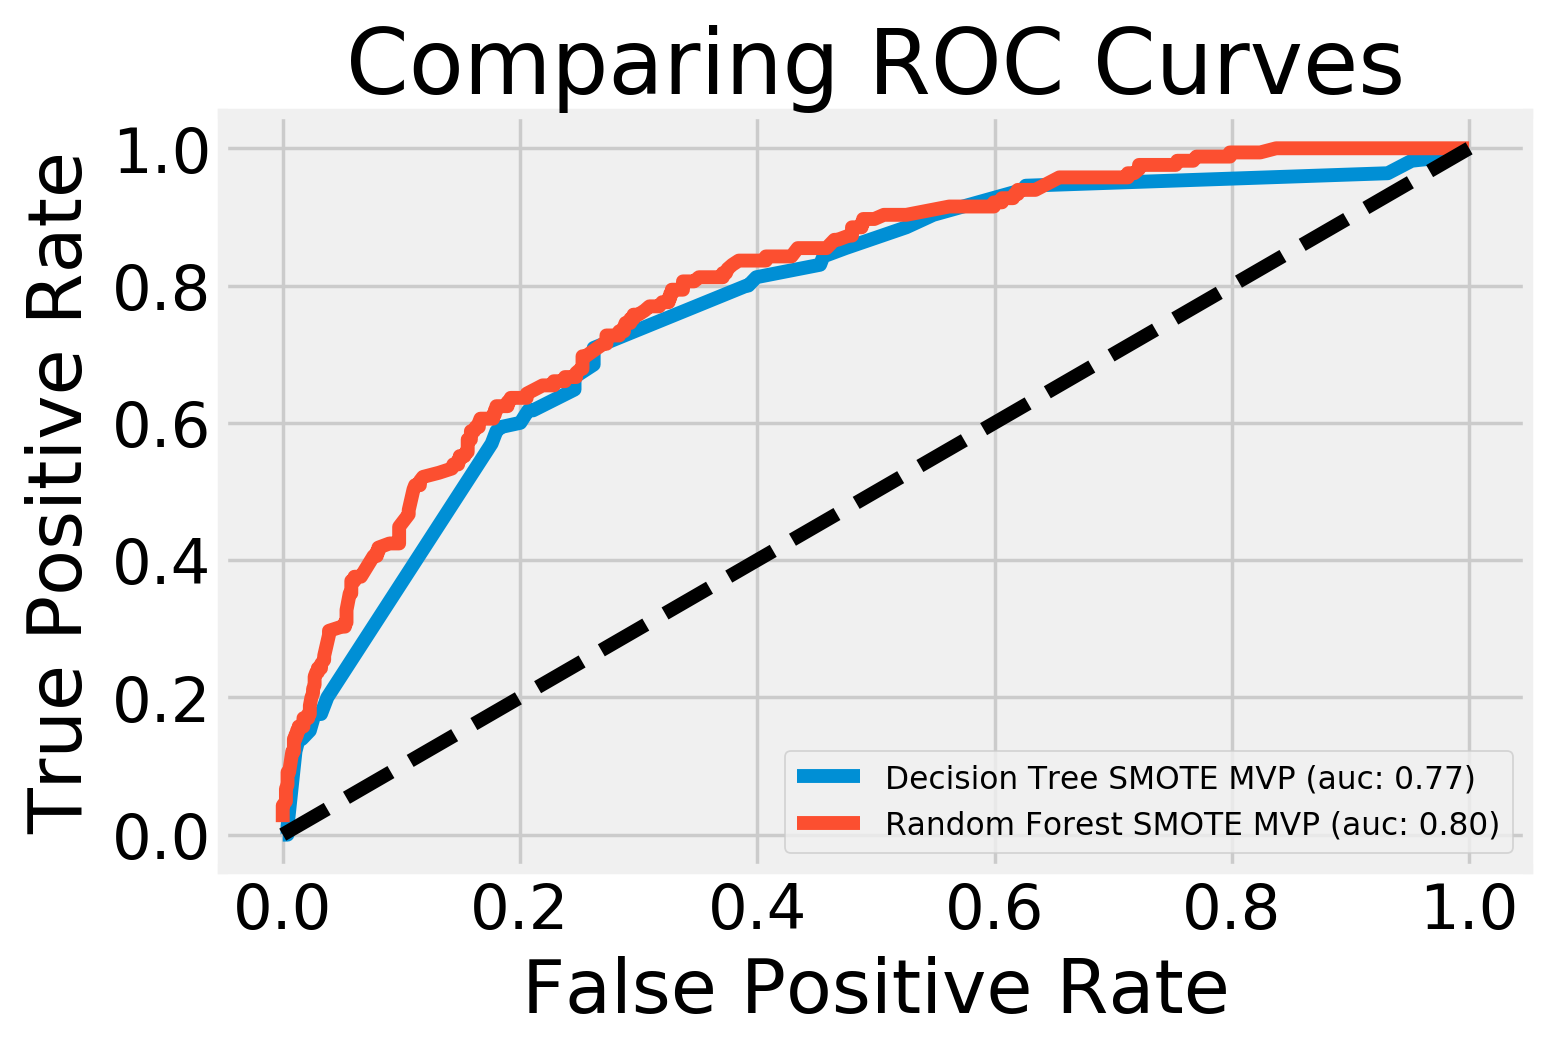

In [805]:
plt.figure(dpi=250)
for name, tpr, fpr, auc_score in roc_plotting_stuff:
    plt.plot(fpr, tpr, label=name+' (auc: %.2f)'%auc_score)
plt.legend(loc='lower right', fontsize=9)
plt.plot([0, 1], [0, 1], color='k', linestyle='--');
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparing ROC Curves");

# REDO WITH LESS FEATURES

In [862]:
y = real_df['Was_Fatal']
X = real_df[['Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Aircraft_Category_Airplane', 'Aircraft_Category_Balloon',
       'Aircraft_Category_Glider', 'Aircraft_Category_Gyrocraft',
       'Aircraft_Category_Helicopter', 'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI',
       'Solo_Flight_No', 'Solo_Flight_Yes']]


X_train, X_FINALtest, y_train, y_FINALtest = train_test_split(X, y, test_size=0.25, random_state=4444, stratify=y)

In [863]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2727 entries, 81228 to 81672
Data columns (total 24 columns):
Season_Fall                          2727 non-null uint8
Season_Spring                        2727 non-null uint8
Season_Summer                        2727 non-null uint8
Season_Winter                        2727 non-null uint8
Aircraft_Category_Airplane           2727 non-null uint8
Aircraft_Category_Balloon            2727 non-null uint8
Aircraft_Category_Glider             2727 non-null uint8
Aircraft_Category_Gyrocraft          2727 non-null uint8
Aircraft_Category_Helicopter         2727 non-null uint8
Flight_Purpose_Aerial Application    2727 non-null uint8
Flight_Purpose_Business              2727 non-null uint8
Flight_Purpose_Ferry                 2727 non-null uint8
Flight_Purpose_Instructional         2727 non-null uint8
Flight_Purpose_Other                 2727 non-null uint8
Flight_Purpose_Personal              2727 non-null uint8
Flight_Purpose_Positioning       

In [864]:
from imblearn.over_sampling import SMOTE
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X_train,y_train)

X_smoted = pd.DataFrame(X_smoted, columns=['Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Aircraft_Category_Airplane', 'Aircraft_Category_Balloon',
       'Aircraft_Category_Glider', 'Aircraft_Category_Gyrocraft',
       'Aircraft_Category_Helicopter', 'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI',
       'Solo_Flight_No', 'Solo_Flight_Yes'])

y_smoted = pd.Series(y_smoted)

In [865]:
# USING SMOTE

models = [LogisticRegression(), KNeighborsClassifier(), GaussianNB(), SVC(),
           DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]
names = ['LR', 'KNN', 'NB', 'SVC', 'Decision Tree', 'Random Forest', 'Gradient Boosted Trees']

for i in range(len(models)):
    
    kf = KFold(random_state = 4444)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    fB = []
    
    for train_index, test_index in kf.split(X_smoted):
        
        kX_train = X_smoted.iloc[train_index]
        kX_test = X_smoted.iloc[test_index]
        ky_train = y_smoted.iloc[train_index]
        ky_test = y_smoted.iloc[test_index]
        
        models[i].fit(kX_train, ky_train)
        y_predict = models[i].predict(kX_test)
        
        accuracy.append(accuracy_score(ky_test, y_predict))
        precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
        recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
        f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
        fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))
    
    accuracy = np.round(np.mean(accuracy), 4)
    precision = np.round(np.mean(precision), 4)
    recall = np.round(np.mean(recall), 4)
    f1 = np.round(np.mean(f1), 4)
    fB = np.round(np.mean(fB), 4)
    
    print('Scores with SMOTE Oversampling -- less features')
    print(f'{names[i]} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
    print('')

Scores with SMOTE Oversampling -- less features
LR accuracy: 0.6463 precision: 0.6391 recall: 0.6582 f1: 0.5921 fB: 0.617

Scores with SMOTE Oversampling -- less features
KNN accuracy: 0.6808 precision: 0.6517 recall: 0.6319 f1: 0.6068 fB: 0.6145

Scores with SMOTE Oversampling -- less features
NB accuracy: 0.6394 precision: 0.7877 recall: 0.1886 f1: 0.2932 fB: 0.2197

Scores with SMOTE Oversampling -- less features
SVC accuracy: 0.6609 precision: 0.6408 recall: 0.6275 f1: 0.5911 fB: 0.6033

Scores with SMOTE Oversampling -- less features
Decision Tree accuracy: 0.651 precision: 0.6296 recall: 0.6832 f1: 0.6002 fB: 0.6338

Scores with SMOTE Oversampling -- less features
Random Forest accuracy: 0.6365 precision: 0.6329 recall: 0.6633 f1: 0.5865 fB: 0.6165

Scores with SMOTE Oversampling -- less features
Gradient Boosted Trees accuracy: 0.6217 precision: 0.624 recall: 0.6931 f1: 0.5841 fB: 0.6271



In [866]:
## FROM DAMIEN'S PAIR PROGRAMMING EXAMPLE

models = [('knn', KNeighborsClassifier), 
          ('logistic', LogisticRegression),
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier)
         ]

param_choices = [
    {
        'n_neighbors': range(1, 12)
    },
    {
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    }
]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_smoted, y_smoted)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

knn: best score: 0.7528014343343792, best estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='uniform')
logistic: best score: 0.7817122366651725, best estimator: LogisticRegression(C=3511.1917342151346, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
tree: best score: 0.7420439264903631, best estimator: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
forest: best score: 0.7628865979381443, best

In [867]:
models = [('logistic', LogisticRegression)]

param_choices = [{
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_smoted, y_smoted)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

logistic: best score: 0.7817122366651725, best estimator: LogisticRegression(C=151991.10829529332, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [868]:
lm2 = grid.best_estimator_
lm2.fit(X_smoted, y_smoted)

LogisticRegression(C=151991.10829529332, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [869]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []
    
for train_index, test_index in kf.split(X_smoted):

    kX_train = X_smoted.iloc[train_index]
    kX_test = X_smoted.iloc[test_index]
    ky_train = y_smoted.iloc[train_index]
    ky_test = y_smoted.iloc[test_index]

    lm1.fit(kX_train, ky_train)
    y_predict = lm2.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print('Scores with SMOTED BALANCE -- Logistic Regress Less Features')
print(f'Logistic Regress accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

Scores with SMOTED BALANCE -- Logistic Regress Less Features
Logistic Regress accuracy: 0.7954 precision: 0.6832 recall: 0.7104 f1: 0.6874 fB: 0.6984



In [870]:
columns = ['Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Aircraft_Category_Airplane', 'Aircraft_Category_Balloon',
       'Aircraft_Category_Glider', 'Aircraft_Category_Gyrocraft',
       'Aircraft_Category_Helicopter', 'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI',
       'Solo_Flight_No', 'Solo_Flight_Yes']

coef_viewer = {}
for col, score in zip(columns, lm2.coef_[0]):
    coef_viewer[col] = score
pd.Series(coef_viewer)

Aircraft_Category_Airplane           0.906386
Aircraft_Category_Balloon            3.425016
Aircraft_Category_Glider             2.838893
Aircraft_Category_Gyrocraft          1.542199
Aircraft_Category_Helicopter         1.800623
Broad_Phase_of_Flight_INFLIGHT       3.118393
Broad_Phase_of_Flight_LANDING        5.238378
Broad_Phase_of_Flight_TAKEOFF        4.369396
Broad_Phase_of_Flight_TAXI           6.550736
Flight_Purpose_Aerial Application    3.335305
Flight_Purpose_Business              2.015166
Flight_Purpose_Ferry                 2.655432
Flight_Purpose_Instructional         2.992605
Flight_Purpose_Other                 2.457997
Flight_Purpose_Personal              1.535880
Flight_Purpose_Positioning           1.275186
Season_Fall                          0.469133
Season_Spring                        0.653995
Season_Summer                        0.730489
Season_Winter                        0.552723
Solo_Flight_No                       0.681658
Solo_Flight_Yes                   

In [871]:
from sklearn.metrics import fbeta_score

kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []

y_predict = lm2.predict(X_FINALtest)

accuracy.append(accuracy_score(y_FINALtest, y_predict))
precision.append(precision_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
recall.append(recall_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
f1.append(f1_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
fB.append(fbeta_score(y_FINALtest, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print(f'TEST Scores with SMOTE Logistic Regression Less Features')
print(f'accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

TEST Scores with SMOTE Logistic Regression Less Features
accuracy: 0.7888 precision: 0.4389 recall: 0.5879 f1: 0.5026 fB: 0.5505



In [872]:
models = [('forest', RandomForestClassifier)]

param_choices = [{
        'n_estimators': [25,50, 100, 200],
        'max_depth': [1,2,3,4,5,7,10],
        'min_samples_leaf': [3,6,10]
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_smoted, y_smoted)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

forest: best score: 0.7754370237561632, best estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [873]:
rf3 = grid.best_estimator_
rf3.fit(X_smoted, y_smoted)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [874]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []
    
for train_index, test_index in kf.split(X_smoted):

    kX_train = X_smoted.iloc[train_index]
    kX_test = X_smoted.iloc[test_index]
    ky_train = y_smoted.iloc[train_index]
    ky_test = y_smoted.iloc[test_index]

    lm1.fit(kX_train, ky_train)
    y_predict = rf3.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print('Scores with SMOTE Oversampling -- RF SMOTED LESS FEATURES')
print(f'RF MVP accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

Scores with SMOTE Oversampling -- RF SMOTED LESS FEATURES
RF MVP accuracy: 0.7918 precision: 0.6703 recall: 0.7578 f1: 0.6975 fB: 0.7283



In [875]:
columns = ['Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Aircraft_Category_Airplane', 'Aircraft_Category_Balloon',
       'Aircraft_Category_Glider', 'Aircraft_Category_Gyrocraft',
       'Aircraft_Category_Helicopter', 'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI',
       'Solo_Flight_No', 'Solo_Flight_Yes']

feature_viewer = {}
for col, score in zip(columns, rf3.feature_importances_):
    feature_viewer[col] = score
pd.Series(feature_viewer)

Aircraft_Category_Airplane           0.022379
Aircraft_Category_Balloon            0.000742
Aircraft_Category_Glider             0.002958
Aircraft_Category_Gyrocraft          0.000518
Aircraft_Category_Helicopter         0.011279
Broad_Phase_of_Flight_INFLIGHT       0.179836
Broad_Phase_of_Flight_LANDING        0.174367
Broad_Phase_of_Flight_TAKEOFF        0.047076
Broad_Phase_of_Flight_TAXI           0.036541
Flight_Purpose_Aerial Application    0.032591
Flight_Purpose_Business              0.013322
Flight_Purpose_Ferry                 0.003447
Flight_Purpose_Instructional         0.038281
Flight_Purpose_Other                 0.028796
Flight_Purpose_Personal              0.097465
Flight_Purpose_Positioning           0.001374
Season_Fall                          0.009846
Season_Spring                        0.012034
Season_Summer                        0.020338
Season_Winter                        0.019904
Solo_Flight_No                       0.030091
Solo_Flight_Yes                   

In [876]:
from sklearn.metrics import fbeta_score

kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []

y_predict = rf3.predict(X_FINALtest)

accuracy.append(accuracy_score(y_FINALtest, y_predict))
precision.append(precision_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
recall.append(recall_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
f1.append(f1_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
fB.append(fbeta_score(y_FINALtest, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print(f'TEST Scores with SMOTE RF Less Features')
print(f'accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

TEST Scores with SMOTE RF Less Features
accuracy: 0.7767 precision: 0.428 recall: 0.6848 f1: 0.5268 fB: 0.6115



In [877]:
models = [('tree', DecisionTreeClassifier)]

param_choices = [{
        'max_depth': [1,2,3,4,5,6,7],
        'min_samples_leaf': [3,6,8,10,12,15]
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_smoted, y_smoted)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

tree: best score: 0.762662483191394, best estimator: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [878]:
dt2 = grid.best_estimator_
dt2.fit(X_smoted, y_smoted)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [879]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []
    
for train_index, test_index in kf.split(X_smoted):

    kX_train = X_smoted.iloc[train_index]
    kX_test = X_smoted.iloc[test_index]
    ky_train = y_smoted.iloc[train_index]
    ky_test = y_smoted.iloc[test_index]

    lm1.fit(kX_train, ky_train)
    y_predict = dt2.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print('Scores with SMOTE Oversampling -- Decision Tree SMOTED LESS FEATURES')
print(f'RF MVP accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

Scores with SMOTE Oversampling -- Decision Tree SMOTED LESS FEATURES
RF MVP accuracy: 0.7716 precision: 0.6648 recall: 0.7326 f1: 0.6804 fB: 0.7059



In [880]:
from sklearn.metrics import fbeta_score

models = [dt2, lm2, rf3]
names = ['Decision Tree SMOTE Less Features', 'LR SMOTE Less Features', 'Random Forest SMOTE Less Features']

for model, name in zip(models, names):

    kf = KFold(random_state = 4444)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    fB = []

    y_predict = model.predict(X_FINALtest)

    accuracy.append(accuracy_score(y_FINALtest, y_predict))
    precision.append(precision_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(y_FINALtest, y_predict, beta=2.0, pos_label = 'Fatal'))

    accuracy = np.round(np.mean(accuracy), 4)
    precision = np.round(np.mean(precision), 4)
    recall = np.round(np.mean(recall), 4)
    f1 = np.round(np.mean(f1), 4)
    fB = np.round(np.mean(fB), 4)

    print(f'FINAL TEST Scores Less Features')
    print(f'{name} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
    print('')

FINAL TEST Scores Less Features
Decision Tree SMOTE Less Features accuracy: 0.7712 precision: 0.4189 recall: 0.6727 f1: 0.5163 fB: 0.6

FINAL TEST Scores Less Features
LR SMOTE Less Features accuracy: 0.7888 precision: 0.4389 recall: 0.5879 f1: 0.5026 fB: 0.5505

FINAL TEST Scores Less Features
Random Forest SMOTE Less Features accuracy: 0.7767 precision: 0.428 recall: 0.6848 f1: 0.5268 fB: 0.6115



In [881]:
feature_selection(X_smoted, y_smoted, 15)

,ExtraTrees FI,Random Forest FI,Recursive LogReg
0,Broad_Phase_of_Flight_INFLIGHT,Broad_Phase_of_Flight_INFLIGHT,Aircraft_Category_Balloon
1,Flight_Purpose_Personal,Flight_Purpose_Personal,Aircraft_Category_Glider
2,Broad_Phase_of_Flight_LANDING,Broad_Phase_of_Flight_LANDING,Aircraft_Category_Helicopter
3,Weather_Condition_VMC,Weather_Condition_VMC,Flight_Purpose_Aerial Application
4,Weather_Condition_IMC,Weather_Condition_IMC,Flight_Purpose_Business
5,Solo_Flight_No,Solo_Flight_Yes,Flight_Purpose_Ferry
6,Flight_Purpose_Instructional,Broad_Phase_of_Flight_TAKEOFF,Flight_Purpose_Instructional
7,Aircraft_Category_Airplane,Flight_Purpose_Other,Flight_Purpose_Other
8,Season_Winter,Flight_Purpose_Instructional,Flight_Purpose_Personal
9,Flight_Purpose_Other,Flight_Purpose_Aerial Application,Weather_Condition_VMC


In [882]:
columns = ['Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Aircraft_Category_Airplane', 'Aircraft_Category_Balloon',
       'Aircraft_Category_Glider', 'Aircraft_Category_Gyrocraft',
       'Aircraft_Category_Helicopter', 'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI',
       'Solo_Flight_No', 'Solo_Flight_Yes']

feature_viewer = {}
for col, score in zip(columns, rf3.feature_importances_):
    feature_viewer[col] = score
pd.Series(feature_viewer)

Aircraft_Category_Airplane           0.022379
Aircraft_Category_Balloon            0.000742
Aircraft_Category_Glider             0.002958
Aircraft_Category_Gyrocraft          0.000518
Aircraft_Category_Helicopter         0.011279
Broad_Phase_of_Flight_INFLIGHT       0.179836
Broad_Phase_of_Flight_LANDING        0.174367
Broad_Phase_of_Flight_TAKEOFF        0.047076
Broad_Phase_of_Flight_TAXI           0.036541
Flight_Purpose_Aerial Application    0.032591
Flight_Purpose_Business              0.013322
Flight_Purpose_Ferry                 0.003447
Flight_Purpose_Instructional         0.038281
Flight_Purpose_Other                 0.028796
Flight_Purpose_Personal              0.097465
Flight_Purpose_Positioning           0.001374
Season_Fall                          0.009846
Season_Spring                        0.012034
Season_Summer                        0.020338
Season_Winter                        0.019904
Solo_Flight_No                       0.030091
Solo_Flight_Yes                   

In [883]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc

models = [dt2, lm2, rf3]
names = ['Decision Tree SMOTE Less Features', 'LR SMOTE Less Features', 'Random Forest SMOTE Less Features']

roc_plotting_stuff = []
for model, name in zip(models, names):
    model.fit(X_smoted, y_smoted)
    preds = model.predict_proba(X_FINALtest)
    fpr, tpr, _ = roc_curve(y_FINALtest, preds[:,0], pos_label = 'Fatal')
    auc_score = auc(fpr, tpr)
    roc_plotting_stuff.append((name, tpr, fpr, auc_score))
    
print(preds)

[[0.23075749 0.76924251]
 [0.69008341 0.30991659]
 [0.22842366 0.77157634]
 ...
 [0.64439233 0.35560767]
 [0.50072318 0.49927682]
 [0.30993097 0.69006903]]


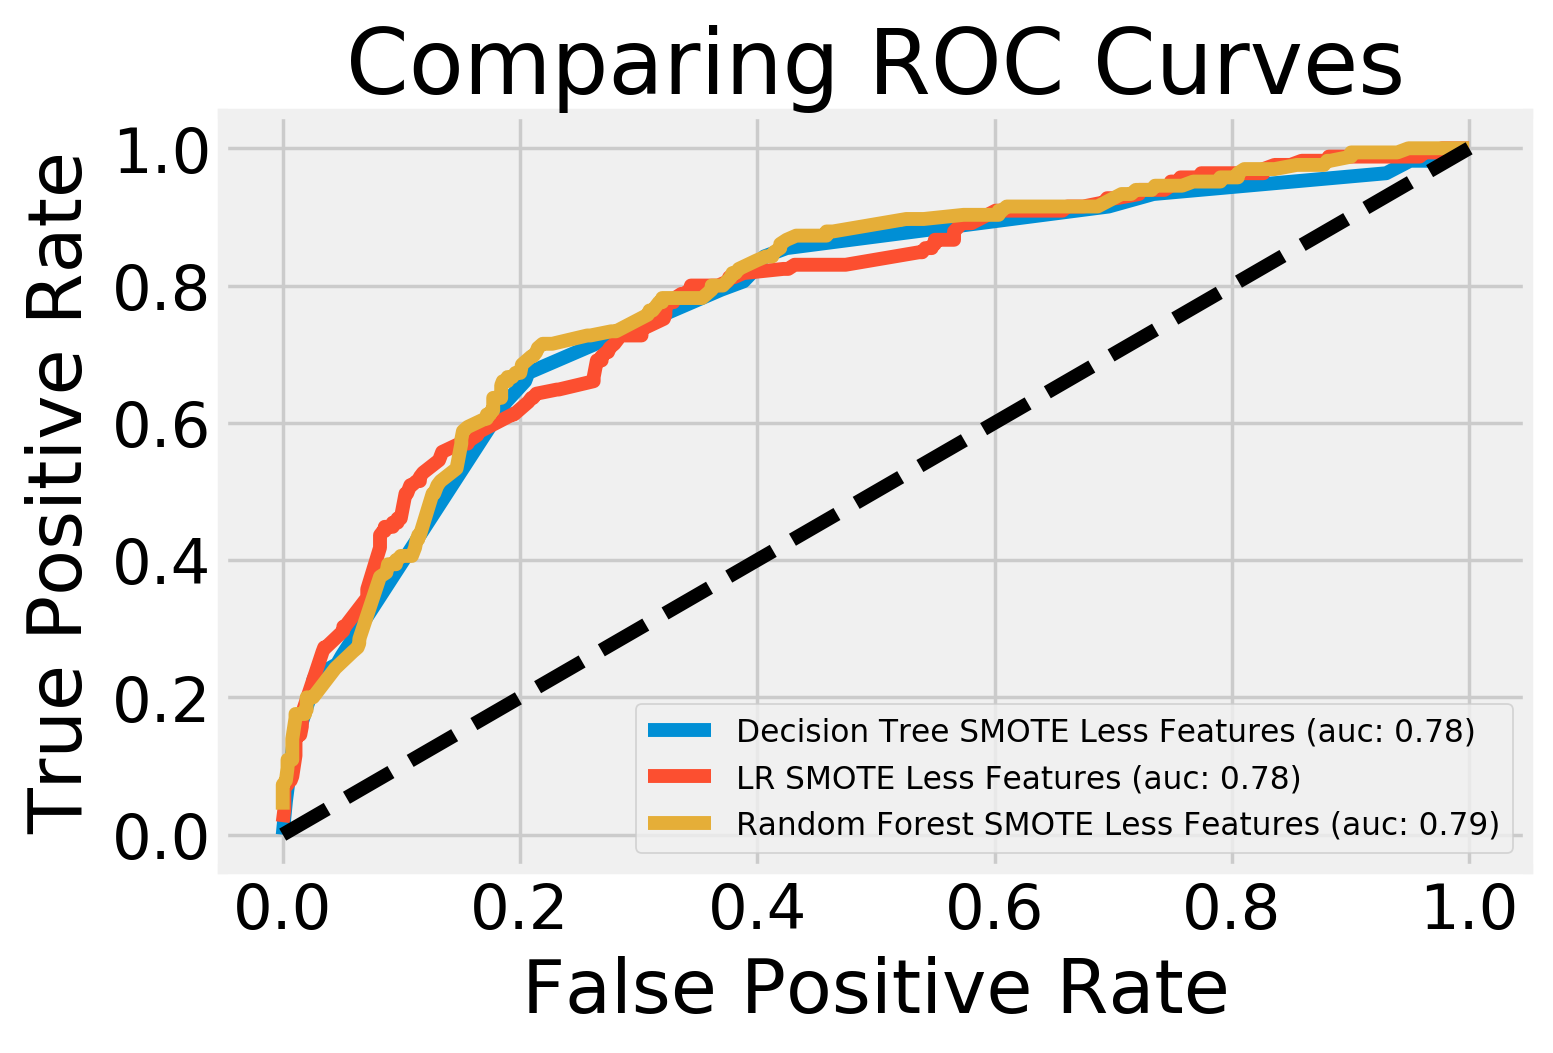

In [884]:
plt.figure(dpi=250)
for name, tpr, fpr, auc_score in roc_plotting_stuff:
    plt.plot(fpr, tpr, label=name+' (auc: %.2f)'%auc_score)
plt.legend(loc='lower right', fontsize=9)
plt.plot([0, 1], [0, 1], color='k', linestyle='--');
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparing ROC Curves");

# REPEAT WITH EVEN LESS FEATURES

In [885]:
y = real_df['Was_Fatal']
X = real_df[['Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI',
       'Solo_Flight_No', 'Solo_Flight_Yes']]


X_train, X_FINALtest, y_train, y_FINALtest = train_test_split(X, y, test_size=0.25, random_state=4444, stratify=y)

In [886]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2727 entries, 81228 to 81672
Data columns (total 19 columns):
Season_Fall                          2727 non-null uint8
Season_Spring                        2727 non-null uint8
Season_Summer                        2727 non-null uint8
Season_Winter                        2727 non-null uint8
Flight_Purpose_Aerial Application    2727 non-null uint8
Flight_Purpose_Business              2727 non-null uint8
Flight_Purpose_Ferry                 2727 non-null uint8
Flight_Purpose_Instructional         2727 non-null uint8
Flight_Purpose_Other                 2727 non-null uint8
Flight_Purpose_Personal              2727 non-null uint8
Flight_Purpose_Positioning           2727 non-null uint8
Weather_Condition_IMC                2727 non-null uint8
Weather_Condition_VMC                2727 non-null uint8
Broad_Phase_of_Flight_INFLIGHT       2727 non-null uint8
Broad_Phase_of_Flight_LANDING        2727 non-null uint8
Broad_Phase_of_Flight_TAKEOFF    

In [887]:
from imblearn.over_sampling import SMOTE
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X_train,y_train)

X_smoted_last = pd.DataFrame(X_smoted, columns=['Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI',
       'Solo_Flight_No', 'Solo_Flight_Yes'])

y_smoted_last = pd.Series(y_smoted)

In [888]:
# USING SMOTE

models = [LogisticRegression(), KNeighborsClassifier(), GaussianNB(), SVC(),
           DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]
names = ['LR', 'KNN', 'NB', 'SVC', 'Decision Tree', 'Random Forest', 'Gradient Boosted Trees']

for i in range(len(models)):
    
    kf = KFold(random_state = 4444)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    fB = []
    
    for train_index, test_index in kf.split(X_smoted_last):
        
        kX_train = X_smoted_last.iloc[train_index]
        kX_test = X_smoted_last.iloc[test_index]
        ky_train = y_smoted_last.iloc[train_index]
        ky_test = y_smoted_last.iloc[test_index]
        
        models[i].fit(kX_train, ky_train)
        y_predict = models[i].predict(kX_test)
        
        accuracy.append(accuracy_score(ky_test, y_predict))
        precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
        recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
        f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
        fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))
    
    accuracy = np.round(np.mean(accuracy), 4)
    precision = np.round(np.mean(precision), 4)
    recall = np.round(np.mean(recall), 4)
    f1 = np.round(np.mean(f1), 4)
    fB = np.round(np.mean(fB), 4)
    
    print('Scores with SMOTE Oversampling -- last features')
    print(f'{names[i]} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
    print('')

Scores with SMOTE Oversampling -- last features
LR accuracy: 0.6111 precision: 0.6256 recall: 0.6453 f1: 0.5631 fB: 0.5936

Scores with SMOTE Oversampling -- last features
KNN accuracy: 0.6517 precision: 0.6495 recall: 0.5968 f1: 0.5776 fB: 0.5803

Scores with SMOTE Oversampling -- last features
NB accuracy: 0.6134 precision: 0.7859 recall: 0.1539 f1: 0.2495 fB: 0.1817

Scores with SMOTE Oversampling -- last features
SVC accuracy: 0.6241 precision: 0.63 recall: 0.6528 f1: 0.5745 fB: 0.6037

Scores with SMOTE Oversampling -- last features
Decision Tree accuracy: 0.6215 precision: 0.6182 recall: 0.6761 f1: 0.5779 fB: 0.616

Scores with SMOTE Oversampling -- last features
Random Forest accuracy: 0.6138 precision: 0.6197 recall: 0.67 f1: 0.5716 fB: 0.6099

Scores with SMOTE Oversampling -- last features
Gradient Boosted Trees accuracy: 0.6015 precision: 0.622 recall: 0.6696 f1: 0.5634 fB: 0.6047



In [889]:
## FROM DAMIEN'S PAIR PROGRAMMING EXAMPLE

models = [('knn', KNeighborsClassifier), 
          ('logistic', LogisticRegression),
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier)
         ]

param_choices = [
    {
        'n_neighbors': range(1, 12)
    },
    {
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    }
]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_smoted_last, y_smoted_last)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

knn: best score: 0.7532496638278798, best estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='uniform')
logistic: best score: 0.7693859255939041, best estimator: LogisticRegression(C=81.11308307896873, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
tree: best score: 0.7398027790228597, best estimator: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
forest: best score: 0.7541461228148812, best

In [890]:
models = [('logistic', LogisticRegression)]

param_choices = [{
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_smoted_last, y_smoted_last)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

logistic: best score: 0.7693859255939041, best estimator: LogisticRegression(C=81.11308307896873, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [891]:
lm3 = grid.best_estimator_
lm3.fit(X_smoted_last, y_smoted_last)

LogisticRegression(C=81.11308307896873, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [892]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []
    
for train_index, test_index in kf.split(X_smoted_last):

    kX_train = X_smoted_last.iloc[train_index]
    kX_test = X_smoted_last.iloc[test_index]
    ky_train = y_smoted_last.iloc[train_index]
    ky_test = y_smoted_last.iloc[test_index]

    lm1.fit(kX_train, ky_train)
    y_predict = lm3.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print('Scores with SMOTED BALANCE -- Logistic Regress Last Features')
print(f'Logistic Regress accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

Scores with SMOTED BALANCE -- Logistic Regress Last Features
Logistic Regress accuracy: 0.7779 precision: 0.6653 recall: 0.7132 f1: 0.6751 fB: 0.6935



In [893]:
columns = ['Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI',
       'Solo_Flight_No', 'Solo_Flight_Yes']

coef_viewer = {}
for col, score in zip(columns, lm3.coef_[0]):
    coef_viewer[col] = score
pd.Series(coef_viewer)

Broad_Phase_of_Flight_INFLIGHT       3.068114
Broad_Phase_of_Flight_LANDING        5.199019
Broad_Phase_of_Flight_TAKEOFF        4.340661
Broad_Phase_of_Flight_TAXI           6.514822
Flight_Purpose_Aerial Application    4.901972
Flight_Purpose_Business              3.648222
Flight_Purpose_Ferry                 4.049896
Flight_Purpose_Instructional         4.711964
Flight_Purpose_Other                 4.013706
Flight_Purpose_Personal              3.162060
Flight_Purpose_Positioning           3.628549
Season_Fall                          0.566866
Season_Spring                        0.765680
Season_Summer                        0.868171
Season_Winter                        0.669833
Solo_Flight_No                       0.704833
Solo_Flight_Yes                      1.402038
Weather_Condition_IMC                1.024550
Weather_Condition_VMC                2.339277
dtype: float64

In [894]:
models = [('forest', RandomForestClassifier)]

param_choices = [{
        'n_estimators': [25,50, 100, 200],
        'max_depth': [1,2,3,4,5,7,10],
        'min_samples_leaf': [3,6,10]
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_smoted_last, y_smoted_last)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

forest: best score: 0.7675930076199013, best estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [895]:
rf4 = grid.best_estimator_
rf4.fit(X_smoted_last, y_smoted_last)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [896]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []
    
for train_index, test_index in kf.split(X_smoted_last):

    kX_train = X_smoted_last.iloc[train_index]
    kX_test = X_smoted_last.iloc[test_index]
    ky_train = y_smoted_last.iloc[train_index]
    ky_test = y_smoted_last.iloc[test_index]

    lm1.fit(kX_train, ky_train)
    y_predict = rf4.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print('Scores with SMOTE Oversampling -- RF SMOTED LESS FEATURES')
print(f'RF MVP accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

Scores with SMOTE Oversampling -- RF SMOTED LESS FEATURES
RF MVP accuracy: 0.7851 precision: 0.6674 recall: 0.7549 f1: 0.6927 fB: 0.7238



In [897]:
columns = ['Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Flight_Purpose_Aerial Application', 'Flight_Purpose_Business',
       'Flight_Purpose_Ferry', 'Flight_Purpose_Instructional',
       'Flight_Purpose_Other', 'Flight_Purpose_Personal',
       'Flight_Purpose_Positioning', 'Weather_Condition_IMC', 'Weather_Condition_VMC',
       'Broad_Phase_of_Flight_INFLIGHT', 'Broad_Phase_of_Flight_LANDING',
       'Broad_Phase_of_Flight_TAKEOFF', 'Broad_Phase_of_Flight_TAXI',
       'Solo_Flight_No', 'Solo_Flight_Yes']

feature_viewer = {}
for col, score in zip(columns, rf4.feature_importances_):
    feature_viewer[col] = score
pd.Series(feature_viewer)

Broad_Phase_of_Flight_INFLIGHT       0.191173
Broad_Phase_of_Flight_LANDING        0.169152
Broad_Phase_of_Flight_TAKEOFF        0.040597
Broad_Phase_of_Flight_TAXI           0.031966
Flight_Purpose_Aerial Application    0.039660
Flight_Purpose_Business              0.015052
Flight_Purpose_Ferry                 0.003283
Flight_Purpose_Instructional         0.044728
Flight_Purpose_Other                 0.023463
Flight_Purpose_Personal              0.101118
Flight_Purpose_Positioning           0.001797
Season_Fall                          0.015561
Season_Spring                        0.012731
Season_Summer                        0.019349
Season_Winter                        0.023437
Solo_Flight_No                       0.031868
Solo_Flight_Yes                      0.035965
Weather_Condition_IMC                0.073650
Weather_Condition_VMC                0.125450
dtype: float64

In [898]:
models = [('tree', DecisionTreeClassifier)]

param_choices = [{
        'max_depth': [1,2,3,4,5,6,7],
        'min_samples_leaf': [3,6,8,10,12,15]
    }]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params)
    grid.fit(X_smoted_last, y_smoted_last)
    s = f"{name}: best score: {grid.best_score_}, best estimator: {grid.best_estimator_}"
    print(s)
    grids[name] = grid

tree: best score: 0.7541461228148812, best estimator: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [899]:
dt3 = grid.best_estimator_
dt3.fit(X_smoted_last, y_smoted_last)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [900]:
kf = KFold(random_state = 4444)
accuracy = []
precision = []
recall = []
f1 = []
fB = []
    
for train_index, test_index in kf.split(X_smoted_last):

    kX_train = X_smoted_last.iloc[train_index]
    kX_test = X_smoted_last.iloc[test_index]
    ky_train = y_smoted_last.iloc[train_index]
    ky_test = y_smoted_last.iloc[test_index]

    lm1.fit(kX_train, ky_train)
    y_predict = dt3.predict(kX_test)

    accuracy.append(accuracy_score(ky_test, y_predict))
    precision.append(precision_score(ky_test, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(ky_test, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(ky_test, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(ky_test, y_predict, beta=2.0, pos_label = 'Fatal'))

accuracy = np.round(np.mean(accuracy), 4)
precision = np.round(np.mean(precision), 4)
recall = np.round(np.mean(recall), 4)
f1 = np.round(np.mean(f1), 4)
fB = np.round(np.mean(fB), 4)

print('Scores with SMOTE Oversampling -- Decision Tree SMOTED LESS FEATURES')
print(f'RF MVP accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
print('')

Scores with SMOTE Oversampling -- Decision Tree SMOTED LESS FEATURES
RF MVP accuracy: 0.7701 precision: 0.6591 recall: 0.7357 f1: 0.6782 fB: 0.7065



In [901]:
predict_y_smoted_last = rf4.predict(X_smoted_last)

In [902]:
import collections

collections.Counter(predict_y_smoted_last)

Counter({'Fatal': 2282, 'Non-fatal': 2180})

In [903]:
collections.Counter(y_smoted_last)

Counter({'Fatal': 2231, 'Non-fatal': 2231})

(SMOTE): The mean of 10 fold cross validation accuracy score on Random Forest model is 0.829


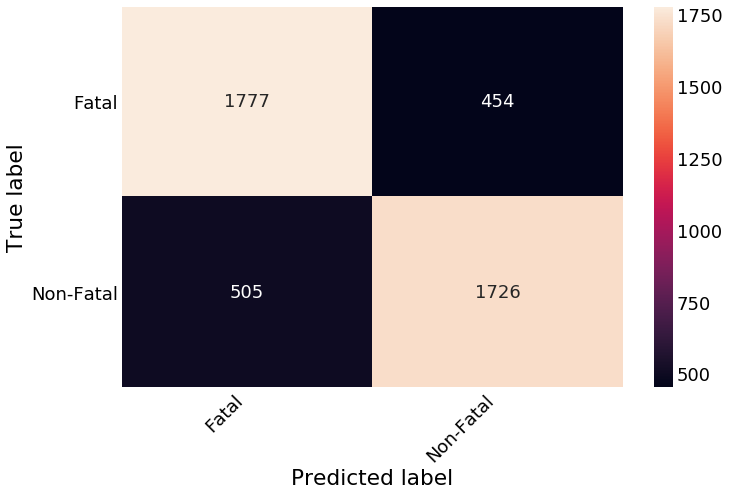

In [904]:
#Checking accuracy score on smoted model
from sklearn.metrics import confusion_matrix

RF_cross_val = cross_val_score(rf4, X_train, y_train, scoring='accuracy', cv = 10)
print('(SMOTE): The mean of 10 fold cross validation accuracy score on Random Forest model is', str(round(np.mean(RF_cross_val), 3)))

RF_smoted_last = confusion_matrix(y_smoted_last, predict_y_smoted_last)
RF_smoted_last = print_confusion_matrix(RF_smoted_last, ['Fatal', 'Non-Fatal'])

In [905]:
models = [dt3, lm3, rf4]
names = ['Decision Tree SMOTE Last Features', 'LR SMOTE Last Features', 'Random Forest SMOTE Last Features']

for model, name in zip(models, names):

    kf = KFold(random_state = 4444)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    fB = []

    y_predict = model.predict(X_FINALtest)

    accuracy.append(accuracy_score(y_FINALtest, y_predict))
    precision.append(precision_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
    recall.append(recall_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
    f1.append(f1_score(y_FINALtest, y_predict, pos_label = 'Fatal'))
    fB.append(fbeta_score(y_FINALtest, y_predict, beta=2.0, pos_label = 'Fatal'))

    accuracy = np.round(np.mean(accuracy), 4)
    precision = np.round(np.mean(precision), 4)
    recall = np.round(np.mean(recall), 4)
    f1 = np.round(np.mean(f1), 4)
    fB = np.round(np.mean(fB), 4)

    print(f'FINAL TEST Scores Last Features')
    print(f'{name} accuracy: {accuracy} precision: {precision} recall: {recall} f1: {f1} fB: {fB}')
    print('')

FINAL TEST Scores Last Features
Decision Tree SMOTE Last Features accuracy: 0.7701 precision: 0.4179 recall: 0.6788 f1: 0.5173 fB: 0.6034

FINAL TEST Scores Last Features
LR SMOTE Last Features accuracy: 0.7877 precision: 0.4412 recall: 0.6364 f1: 0.5211 fB: 0.5846

FINAL TEST Scores Last Features
Random Forest SMOTE Last Features accuracy: 0.7745 precision: 0.4242 recall: 0.6788 f1: 0.5221 fB: 0.6061



In [906]:
feature_selection(X_smoted_last, y_smoted_last, 15)

,ExtraTrees FI,Random Forest FI,Recursive LogReg
0,Broad_Phase_of_Flight_INFLIGHT,Broad_Phase_of_Flight_INFLIGHT,Flight_Purpose_Aerial Application
1,Broad_Phase_of_Flight_LANDING,Broad_Phase_of_Flight_LANDING,Flight_Purpose_Business
2,Flight_Purpose_Personal,Flight_Purpose_Personal,Flight_Purpose_Ferry
3,Weather_Condition_VMC,Weather_Condition_VMC,Flight_Purpose_Instructional
4,Weather_Condition_IMC,Weather_Condition_IMC,Flight_Purpose_Other
5,Broad_Phase_of_Flight_TAKEOFF,Broad_Phase_of_Flight_TAKEOFF,Flight_Purpose_Personal
6,Flight_Purpose_Instructional,Flight_Purpose_Instructional,Flight_Purpose_Positioning
7,Solo_Flight_Yes,Flight_Purpose_Other,Weather_Condition_IMC
8,Solo_Flight_No,Season_Winter,Weather_Condition_VMC
9,Season_Winter,Solo_Flight_Yes,Broad_Phase_of_Flight_INFLIGHT


In [907]:
models = [dt3, lm3, rf4]
names = ['Decision Tree SMOTE Last Features', 'LR SMOTE Last Features', 'Random Forest SMOTE Last Features']

roc_plotting_stuff = []
for model, name in zip(models, names):
    model.fit(X_smoted_last, y_smoted_last)
    preds = model.predict_proba(X_FINALtest)
    fpr, tpr, _ = roc_curve(y_FINALtest, preds[:,0], pos_label = 'Fatal')
    auc_score = auc(fpr, tpr)
    roc_plotting_stuff.append((name, tpr, fpr, auc_score))
    
print(preds)

[[0.19292582 0.80707418]
 [0.68362552 0.31637448]
 [0.30067348 0.69932652]
 ...
 [0.6325234  0.3674766 ]
 [0.4478942  0.5521058 ]
 [0.27327969 0.72672031]]


Text(0.5,1,'Comparing ROC Curves')

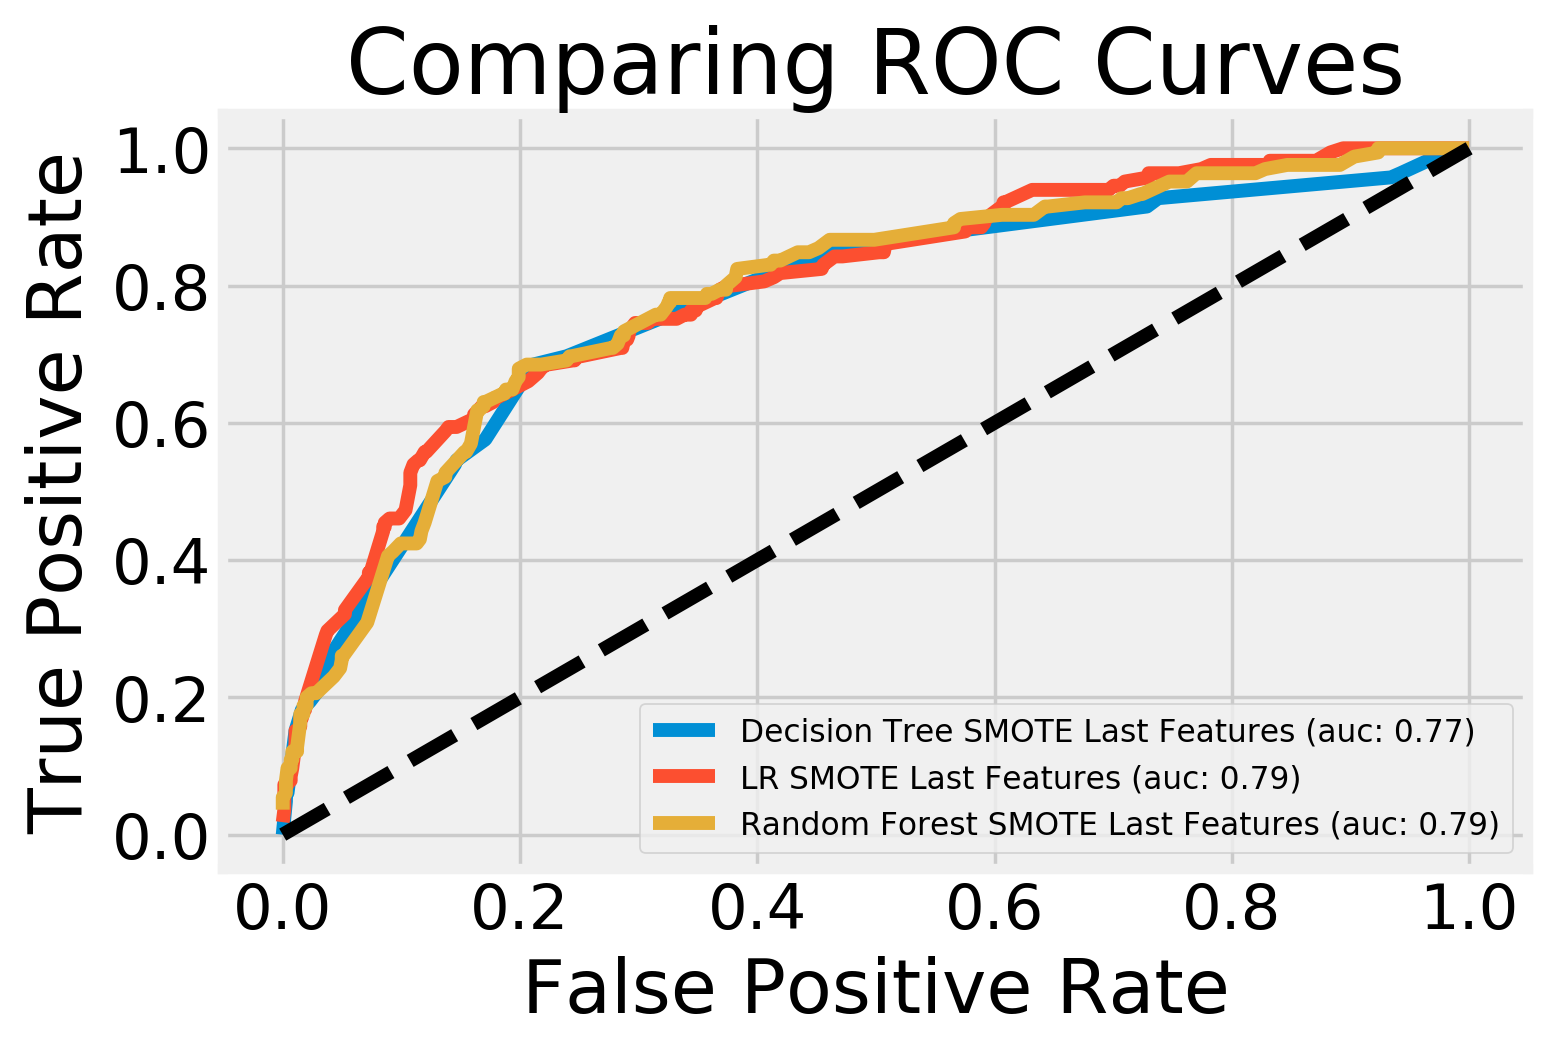

In [908]:
plt.figure(dpi=250)
for name, tpr, fpr, auc_score in roc_plotting_stuff:
    plt.plot(fpr, tpr, label=name+' (auc: %.2f)'%auc_score)
plt.legend(loc='lower right', fontsize=9)
plt.plot([0, 1], [0, 1], color='k', linestyle='--');
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparing ROC Curves")

In [909]:
predict_y_FINALtest = rf4.predict(X_FINALtest)

In [910]:
collections.Counter(predict_y_FINALtest)

Counter({'Fatal': 269, 'Non-fatal': 640})

In [911]:
collections.Counter(y_FINALtest)

Counter({'Fatal': 165, 'Non-fatal': 744})

(SMOTE): The mean of 10 fold cross validation accuracy score on Random Forest model is 0.833


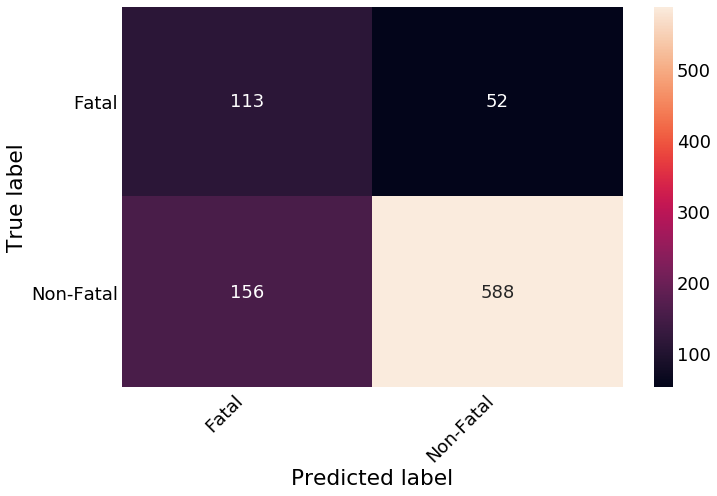

In [912]:
#Checking final accuracy of model

RF_cross_val = cross_val_score(rf4, X_FINALtest, y_FINALtest, scoring='accuracy', cv = 10)
print('(SMOTE): The mean of 10 fold cross validation accuracy score on Random Forest model is', str(round(np.mean(RF_cross_val), 3)))

RF_smoted_last = confusion_matrix(y_FINALtest, predict_y_FINALtest)
RF_smoted_last = print_confusion_matrix(RF_smoted_last, ['Fatal', 'Non-Fatal'])

In [913]:
Fatal_correct = 115 / (115 + 50)
Fatal_correct

0.696969696969697

In [914]:
predict_y_FINALtest = lm3.predict(X_FINALtest)

In [915]:
collections.Counter(predict_y_FINALtest)

Counter({'Fatal': 238, 'Non-fatal': 671})

In [916]:
collections.Counter(y_FINALtest)

Counter({'Fatal': 165, 'Non-fatal': 744})

(SMOTE): The mean of 10 fold cross validation accuracy score on Logistic Regression model is 0.841


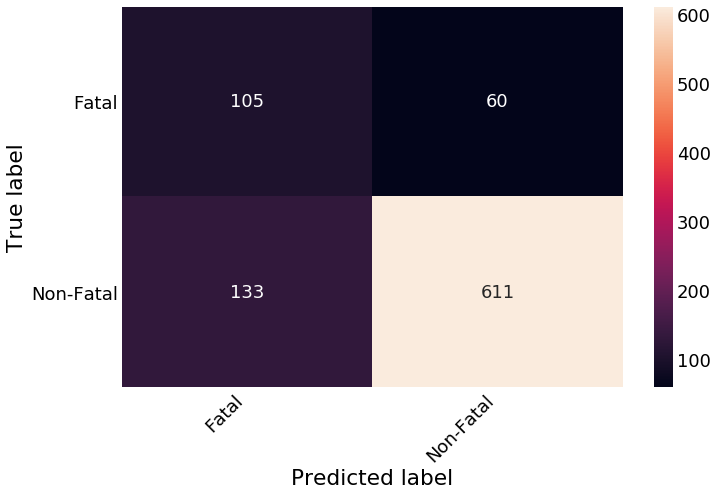

In [917]:
#Checking final accuracy of model

RF_cross_val = cross_val_score(lm3, X_FINALtest, y_FINALtest, scoring='accuracy', cv = 10)
print('(SMOTE): The mean of 10 fold cross validation accuracy score on Logistic Regression model is', str(round(np.mean(RF_cross_val), 3)))

RF_smoted_last = confusion_matrix(y_FINALtest, predict_y_FINALtest)
RF_smoted_last = print_confusion_matrix(RF_smoted_last, ['Fatal', 'Non-Fatal'])

.315